In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [38]:
def show_image(title, image):
    """
    Displays an image with a given title using matplotlib.

    Args:
        title (str): The title of the image window.
        image (numpy.ndarray): The image to display.
    """
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

Crop barcode

In [39]:
def detect_crop_barcode(image, output_path):
    """
    Detects a barcode in the given image, crops it, and saves the straightened barcode image to the specified output path.

    Args:
        image (numpy.ndarray): The input image in which to detect the barcode.
        output_path (str): The file path where the cropped and straightened barcode image will be saved.

    Returns:
        bool: True if a barcode was detected and saved successfully, False otherwise.
    """
    # Convert the image to grayscale

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(image, (9, 9), 0)

    # Apply edge detection
    edged = cv2.Canny(blurred, 50, 200, 255)

    # Apply morphological operations to close gaps in the edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

    # Show the edged image
    show_image("Edged Image", edged)
    show_image("Closed Image", closed)

    # Find contours in the closed image
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area, keeping only the largest one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    barcode_contour = None

    # Loop over the contours to find the one that likely represents the barcode
    for contour in contours:
        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # If the approximated contour has four points, we can assume we have found the barcode
        if len(approx) == 4:
            barcode_contour = approx
            break

    if barcode_contour is not None:
        # Get the points of the contour (in order of top-left, top-right, bottom-right, bottom-left)
        points = barcode_contour.reshape(4, 2)

        # Order the points in a consistent way
        points = sorted(points, key=lambda x: x[0])
        (tl, tr) = sorted(points[:2], key=lambda x: x[1])  # top-left, top-right
        (bl, br) = sorted(points[2:], key=lambda x: x[1])  # bottom-left, bottom-right

        # The ordered points for the perspective transform
        ordered_points = np.array([tl, tr, br, bl], dtype="float32")

        # Define the width and height of the new image (horizontal rectangle)
        width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
        height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))

        # Define the destination points for the perspective transform (a rectangular region)
        destination_points = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype="float32")

        # Compute the perspective transform matrix
        matrix = cv2.getPerspectiveTransform(ordered_points, destination_points)

        # Apply the perspective transform to straighten the barcode region
        straightened_image = cv2.warpPerspective(image, matrix, (width, height))

        # Check if the image is taller than it is wide
        if straightened_image.shape[0] > straightened_image.shape[1]:
            # Rotate the image to make it horizontal (counterclockwise rotation)
            straightened_image = cv2.rotate(straightened_image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Show the straightened barcode
        show_image("Straightened Barcode", straightened_image)

        # Save the straightened image
        cv2.imwrite(output_path, straightened_image)
        print(f"Straightened image saved to {output_path}")
        return True
    else:
        print("No barcode detected")
        return False

In [40]:
def crop_largest_rectangle(image, output_path):
    """
    Detects the largest rectangular contour in the given image, crops it, and saves the straightened rectangle image to the specified output path.

    Args:
        image (numpy.ndarray): The input image in which to detect the largest rectangle.
        output_path (str): The file path where the cropped and straightened rectangle image will be saved.
    """
    # Invert the image
    inverted = cv2.bitwise_not(image)

    # Threshold the image (binarize)
    _, thresh = cv2.threshold(inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological closing to fill small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find external contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("No contours found.")
        return

    # Find the largest contour based on area
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the minimum area bounding rectangle around the contour
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.int32(box)  # Convert to integer points

    # Draw the detected rectangle on the original image (for visualization)
    image_copy = image.copy()
    cv2.drawContours(image_copy, [box], -1, (0, 255, 0), 2)
    show_image("Detected Rectangle", image_copy)

    # Perspective transformation
    width, height = int(rect[1][0]), int(rect[1][1])
    if width < height:
        width, height = height, width  # Ensure width is the longer side

    src_pts = box.astype("float32")
    dst_pts = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")

    # Compute the perspective transform matrix
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(image, matrix, (width, height))
    warped = cv2.medianBlur(cv2.blur(warped, (1, 9000)), 3)  # Apply a median filter first
    _, warped = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply Otsu's thresholding

    # Show and save the result
    show_image("Cropped Rectangle", warped)
    cv2.imwrite(output_path, warped)
    print(f"Cropped rectangle saved to {output_path}")

Detect Noises Functions


In [41]:
detected_noises = []  # Detected noise types


Salt and Pepper

In [42]:
threshold_sp = 20

def fix_salt_pepper(image):
    """
    Fixes salt-and-pepper noise in the given image using median and Otsu's thresholding.

    Args:
        processed_image (numpy.ndarray): The input image with salt-and-pepper noise.

    Returns:
        numpy.ndarray: The processed image with reduced salt-and-pepper noise.
    """
    processed_image = cv2.medianBlur(cv2.blur(image, (1, 7)), 3)  # Apply a median filter first
    _, processed_image = cv2.threshold(processed_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply Otsu's thresholding
    return processed_image

def detect_fix_salt_pepper_noise(image):
    """
    Detects and fixes salt-and-pepper noise in the given image.

    Args:
        image (numpy.ndarray): The input image to check for salt-and-pepper noise.

    Returns:
        numpy.ndarray: The processed image with reduced salt-and-pepper noise if detected.
    """
    # Check for salt-and-pepper noise
    median_diff = np.mean(np.abs(image - cv2.medianBlur(image, 3)))
    if median_diff > threshold_sp:
        detected_noises.append('salt_pepper')
        image = fix_salt_pepper(image)
    cv2.imwrite("salt_pepper.jpg", image)
    return image

sine wave 

In [43]:
def detect_fix_noise_sine_waves(image, z_score_threshold=2.5, low_freq_cutoff_ratio=0.02, high_freq_cutoff_ratio=0.5):
        """
        Detect noise sine waves in an image while avoiding structured patterns (e.g., barcodes).

        Parameters:
            image (numpy.ndarray): Input image (grayscale).
            z_score_threshold (float): Z-score threshold for detecting noise.
            low_freq_cutoff_ratio (float): Low frequency cutoff as a ratio of image size.
            high_freq_cutoff_ratio (float): High frequency cutoff as a ratio of image size.

        Returns:
            numpy.ndarray: Binary mask highlighting detected sine wave noise.
        """


        # Step 1: Apply FFT to transform the image to the frequency domain
        dft = np.fft.fft2(image)
        dft_shift = np.fft.fftshift(dft)
        magnitude_spectrum = np.abs(dft_shift)

        # Step 2: Compute z-scores of the magnitude spectrum
        mean_mag = np.mean(magnitude_spectrum)
        std_mag = np.std(magnitude_spectrum)
        z_scores = (magnitude_spectrum - mean_mag) / std_mag

        # Step 3: Create a frequency filter
        rows, cols = image.shape
        center_row, center_col = rows // 2, cols // 2
        low_freq_cutoff = int(min(rows, cols) * low_freq_cutoff_ratio)
        high_freq_cutoff = int(min(rows, cols) * high_freq_cutoff_ratio)

        # Create a circular band-pass filter
        y, x = np.ogrid[:rows, :cols]
        distance_from_center = np.sqrt((x - center_col)**2 + (y - center_row)**2)
        band_pass_filter = (distance_from_center >= low_freq_cutoff) & (distance_from_center <= high_freq_cutoff)

        # Exclude central frequencies (structured patterns like barcodes)
        exclusion_width = int(min(rows, cols) * 0.05)  # Exclude a small width around central axes
        band_pass_filter[center_row - exclusion_width:center_row + exclusion_width, :] = False
        band_pass_filter[:, center_col - exclusion_width:center_col + exclusion_width] = False

        # Apply the band-pass filter to the z-score mask
        sine_wave_mask = (z_scores > z_score_threshold) & band_pass_filter

        # Step 4: Enhance the detected regions using dilation
        kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size to control dilation
        enhanced_mask = cv2.dilate(sine_wave_mask.astype(np.uint8), kernel, iterations=1)

        # Step 5: Create an output image highlighting the sine wave noise
        sine_wave_image = np.zeros_like(image)
        sine_wave_image[enhanced_mask > 0] = 255  # Highlight detected noise patterns



        # DEBUG: Display the magnitude spectrum, filter, and detection
        plt.figure(figsize=(15, 8))

        plt.subplot(1, 3, 1)
        plt.title("Magnitude Spectrum (Log Scale)")
        plt.imshow(np.log(1 + magnitude_spectrum), cmap='gray')
        plt.colorbar()
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Band-Pass Filter")
        plt.imshow(band_pass_filter, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Enhanced Sine Wave Noise")
        plt.imshow(sine_wave_image, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Check if any sine waves were detected
        if np.any(enhanced_mask):
            print("Noise sine waves detected.")
            detected_noises.append('sine_wave')
            detect_crop_barcode(image, 'output.jpg')
            image = cv2.imread('output.jpg', cv2.IMREAD_GRAYSCALE)

            adaptive_thresh = cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 10
            )

            # Display the results
            plt.figure(figsize=(15, 8))
            plt.subplot(1, 2, 1), plt.title("Original Image")
            plt.imshow(image, cmap='gray'), plt.axis('off')
            plt.subplot(1, 2, 2), plt.title("Adaptive Thresholding Result")
            plt.imshow(adaptive_thresh, cmap='gray'), plt.axis('off')
            plt.show()

            adaptive_thresh = cv2.medianBlur(cv2.blur(adaptive_thresh, (1, 9000)), 3)  # Apply a median filter first
            _, adaptive_thresh = cv2.threshold(adaptive_thresh, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply Otsu's thresholding


            #write the image
            cv2.imwrite('output.jpg', adaptive_thresh)

        else:
            print("No noise sine waves detected.")



Brightness

In [44]:
def detect_adjust_brightness(image, target_brightness=128, threshold=60):
    """
    Detects and adjusts brightness issues in the given image.

    Args:
        image (numpy.ndarray): The input image.
        target_brightness (int): The desired average brightness level.
        threshold (int): The threshold for brightness adjustment.

    Returns:
        numpy.ndarray: The processed image with adjusted brightness if needed.
    """

    avg_brightness = np.mean(image)
    print(f"Average brightness: {avg_brightness}")
    if abs(target_brightness - avg_brightness) > threshold:
        print("Brightness adjustment needed.")

        _, gray_binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        show_image("Binarized Grayscale Image", gray_binary)
        detected_noises.append('brightness')
        cv2.imwrite("brightness.jpg", gray_binary)
        return gray_binary
    else:
        print("Brightness is within acceptable range.")
    return image

Contrast

In [45]:
def detect_fix_low_contrast(image, threshold=22):
    """
    Detects and fixes low contrast issues in the given image.

    Args:
        image (numpy.ndarray): The input image.
        threshold (int): The threshold for detecting low contrast.

    Returns:
        numpy.ndarray: The processed image with adjusted contrast if needed.
    """
    min_pixel = np.min(image)
    max_pixel = np.max(image)
    contrast_range = max_pixel - min_pixel

    print(f"Min Intensity: {min_pixel}, Max Intensity: {max_pixel}, Contrast Range: {contrast_range}")

    is_low_contrast = contrast_range < threshold
    if is_low_contrast:
        print("Low contrast detected")
        detected_noises.append('low_contrast')
        _, binary_image = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        cv2.imwrite("low_contrast.jpg", binary_image)
        return binary_image
    else:
        print("Contrast is within acceptable range. No adjustments needed.")
        return image

In [46]:
def detect_noises(image_path):
    """
    Detects and fixes various noises in the given image.

    Args:
        image_path (str): The path to the input image.
    """
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Read the image in color
    image2 = cv2.imread(image_path)

    # Convert the color image to grayscale
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding to the grayscale color image
    _, image2 = cv2.threshold(image2_gray, 20, 255, cv2.THRESH_BINARY)

    # Detect and fix salt-and-pepper noise
    image = detect_fix_salt_pepper_noise(image)

    # Detect and fix low contrast
    image = detect_fix_low_contrast(image)

    # Detect and adjust brightness issues
    image = detect_adjust_brightness(image)

    # Display the processed image
    plt.imshow(image, cmap='gray')

    # Detect and crop barcode
    found = detect_crop_barcode(image, 'output.jpg')

    if not found:
        # Crop the largest rectangle if no barcode is found
        crop_largest_rectangle(image2, 'output.jpg')
    if found:
        # Detect and fix sine wave noise if barcode is found
        detect_fix_noise_sine_waves(image)


Test Detect

In [47]:
def decode(image_path):
    """
    Decodes a barcode from the given image.

    Args:
        image_path (str): The path to the input image.

    Returns:
        bool: True if the barcode was successfully decoded, False otherwise.
    """
    decoded = True
    my_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in your image
    mean = my_image.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 128] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    for pixel in pixels:
        if pixel == "0":
            pixels = pixels[1:-1]
        else:
            break

    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break



    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):
        if skip_next:
            print(pixels[pixel_index])
            while pixels[pixel_index] == '0':
                pixel_index += 1
                if pixel_index >= len(pixels):
                    break
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        current_digit_widths += NARROW if count <= narrow_bar_size + 2 else WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it
        if len(current_digit_widths) > 5:
            decoded = False
            return decoded
    print("----------------------------------")
    print(digits)
    print("----------------------------------\n\n")
    return decoded

In [48]:
def decode_barcode():
    is_decoded = decode("output.jpg")
    if is_decoded:
        print("Barcode decoded successfully")
    else:
        image = cv2.imread('output.jpg', cv2.IMREAD_GRAYSCALE)

        if image is None:
            print("Error: Image not found or unable to load.")
        else:
            print("Image loaded successfully.")

        # Apply thresholding to convert to binary (black and white)
        _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

        # Create a kernel for morphological operations
        kernel = np.ones((5, 2), np.uint8)  # vertical kernel for 1D barcode lines


        # Apply erosion if the lines are too thick after dilation
        eroded_image = cv2.erode(thresh, kernel, iterations=1)

        # Save or process the result
        cv2.imwrite('output.jpg', eroded_image)

        decode("output.jpg")


In [49]:
def process_images_in_folder(folder_path):
    """
    Processes each image in the specified folder by running detect_noises and decode_barcode functions.

    Args:
        folder_path (str): The path to the folder containing images.
    """
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(folder_path, filename)


            if image_path is not None:
                print(f"Processing {filename}...")

                # Run detect_noises function
                detect_noises(image_path)
                print(detected_noises)
                detected_noises.clear()

                # Run decode_barcode function
                decode_barcode()
            else:
                print(f"Failed to load {filename}")

Processing 01 - lol easy.jpg...
Min Intensity: 0, Max Intensity: 255, Contrast Range: 255
Contrast is within acceptable range. No adjustments needed.
Average brightness: 230.07958125
Brightness adjustment needed.


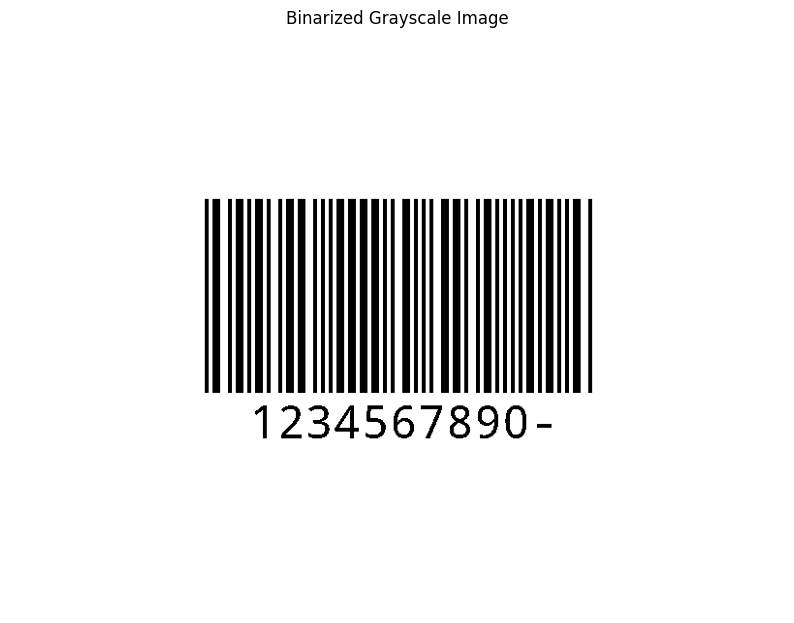

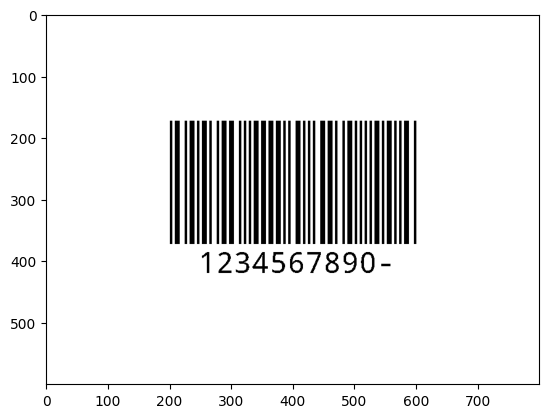

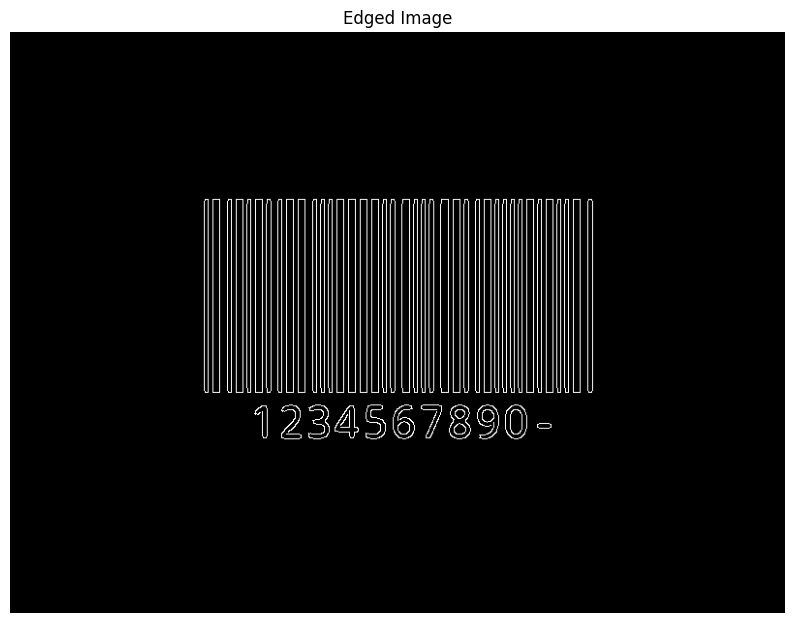

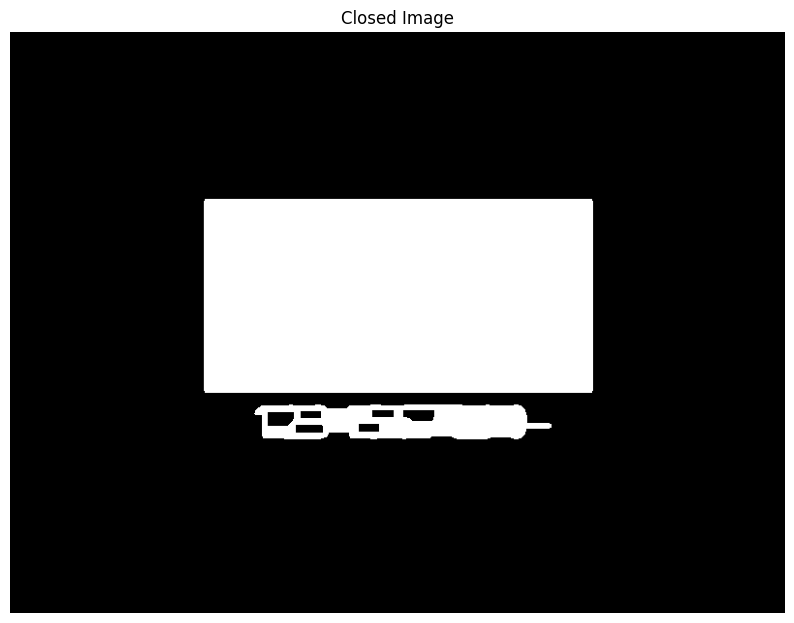

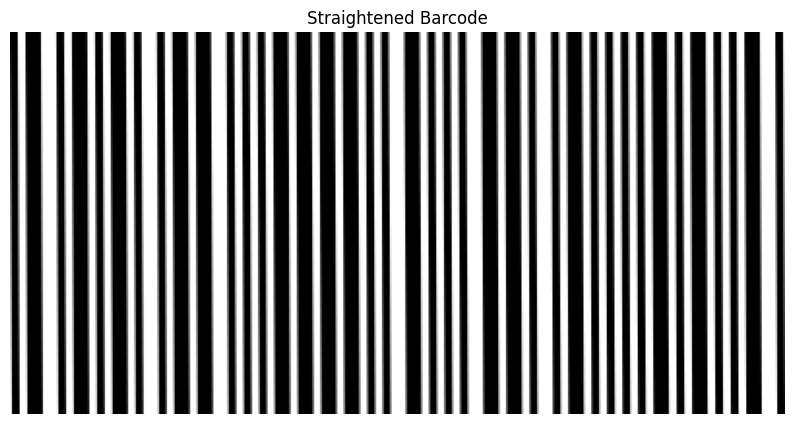

Straightened image saved to output.jpg


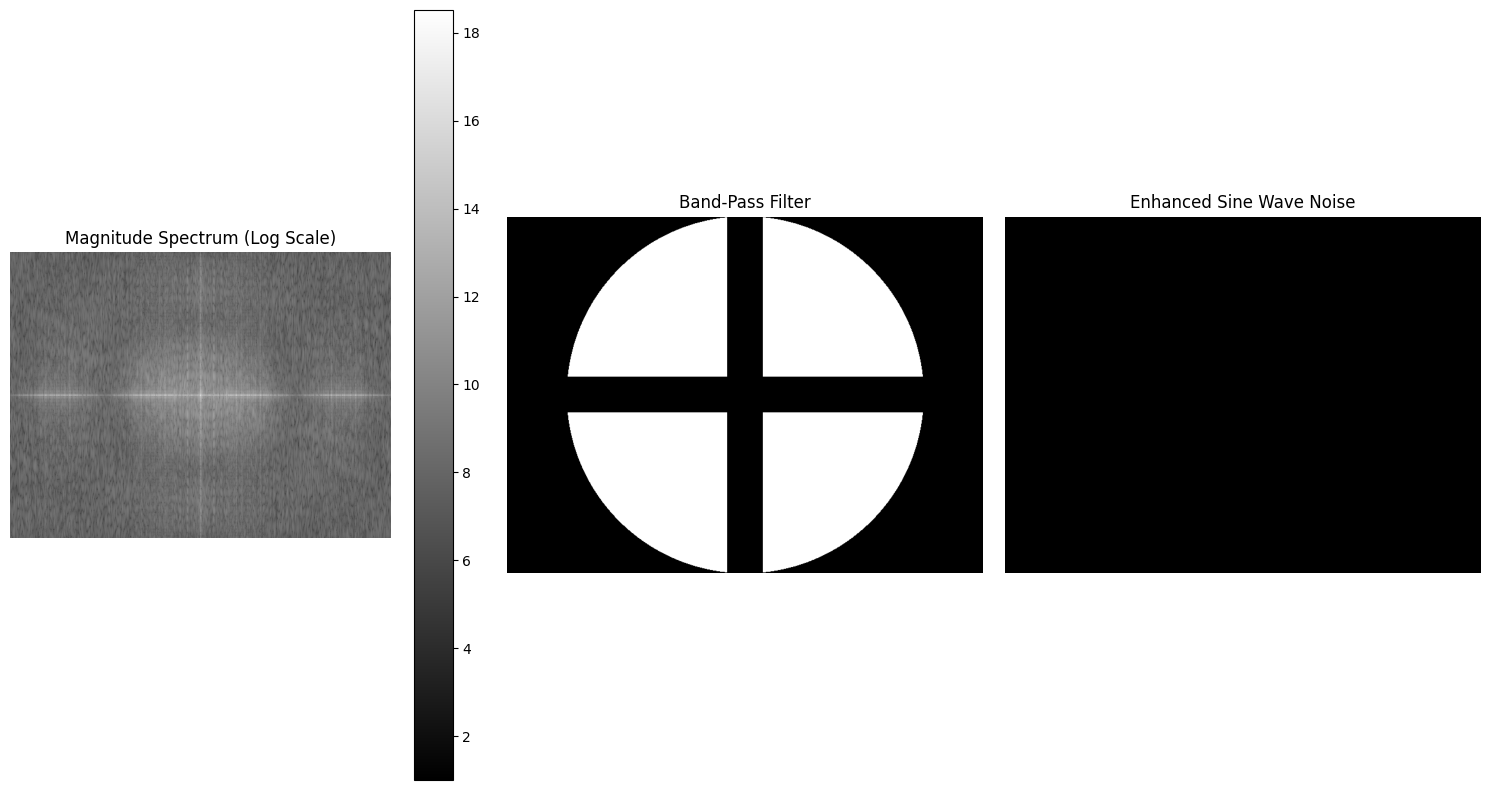

No noise sine waves detected.
['brightness']
0
0
0
0
0
0
0
0
0
0
0
0
----------------------------------
['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']
----------------------------------


Barcode decoded successfully
Processing 02 - still easy.jpg...
Min Intensity: 0, Max Intensity: 255, Contrast Range: 255
Contrast is within acceptable range. No adjustments needed.
Average brightness: 229.14026458333333
Brightness adjustment needed.


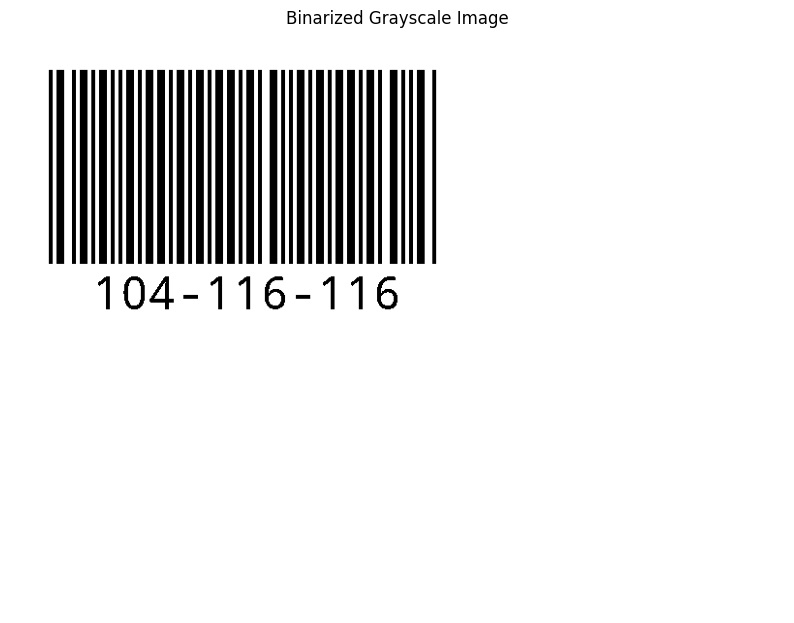

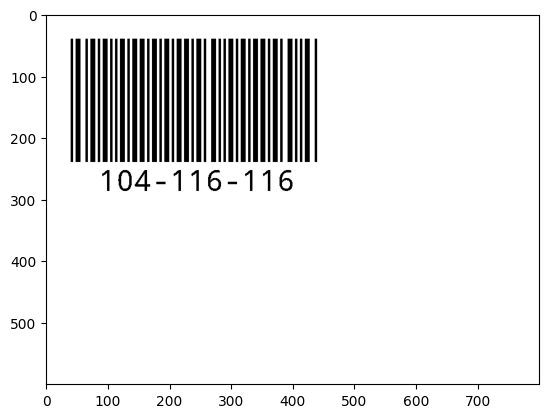

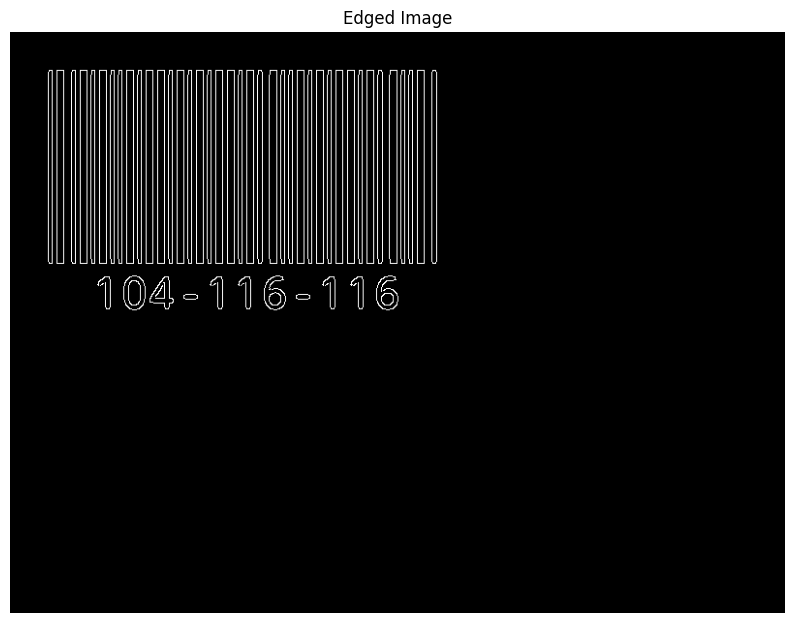

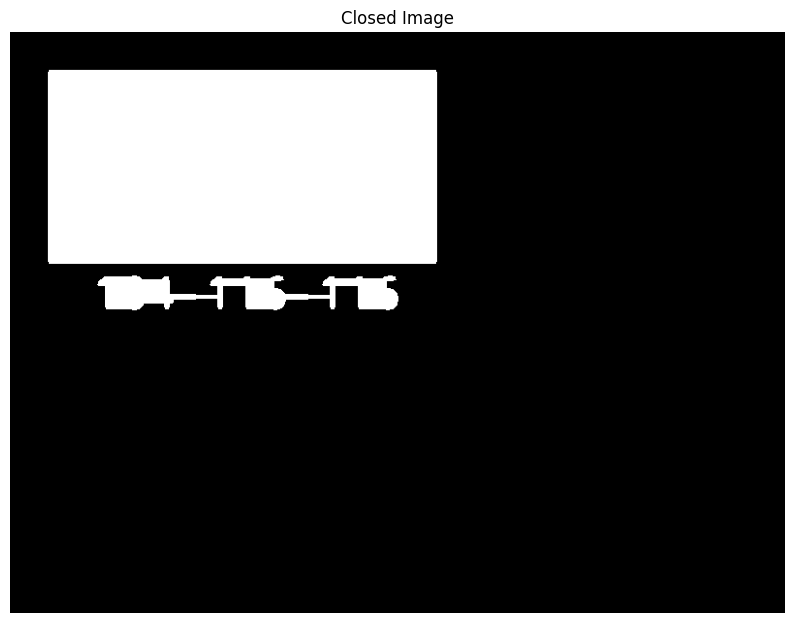

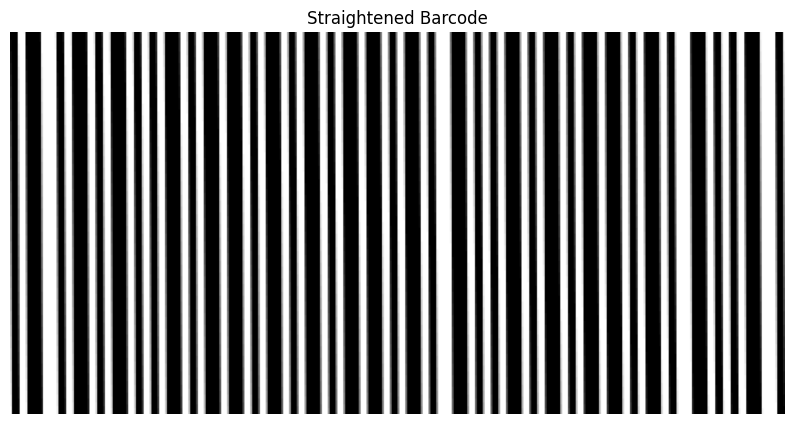

Straightened image saved to output.jpg


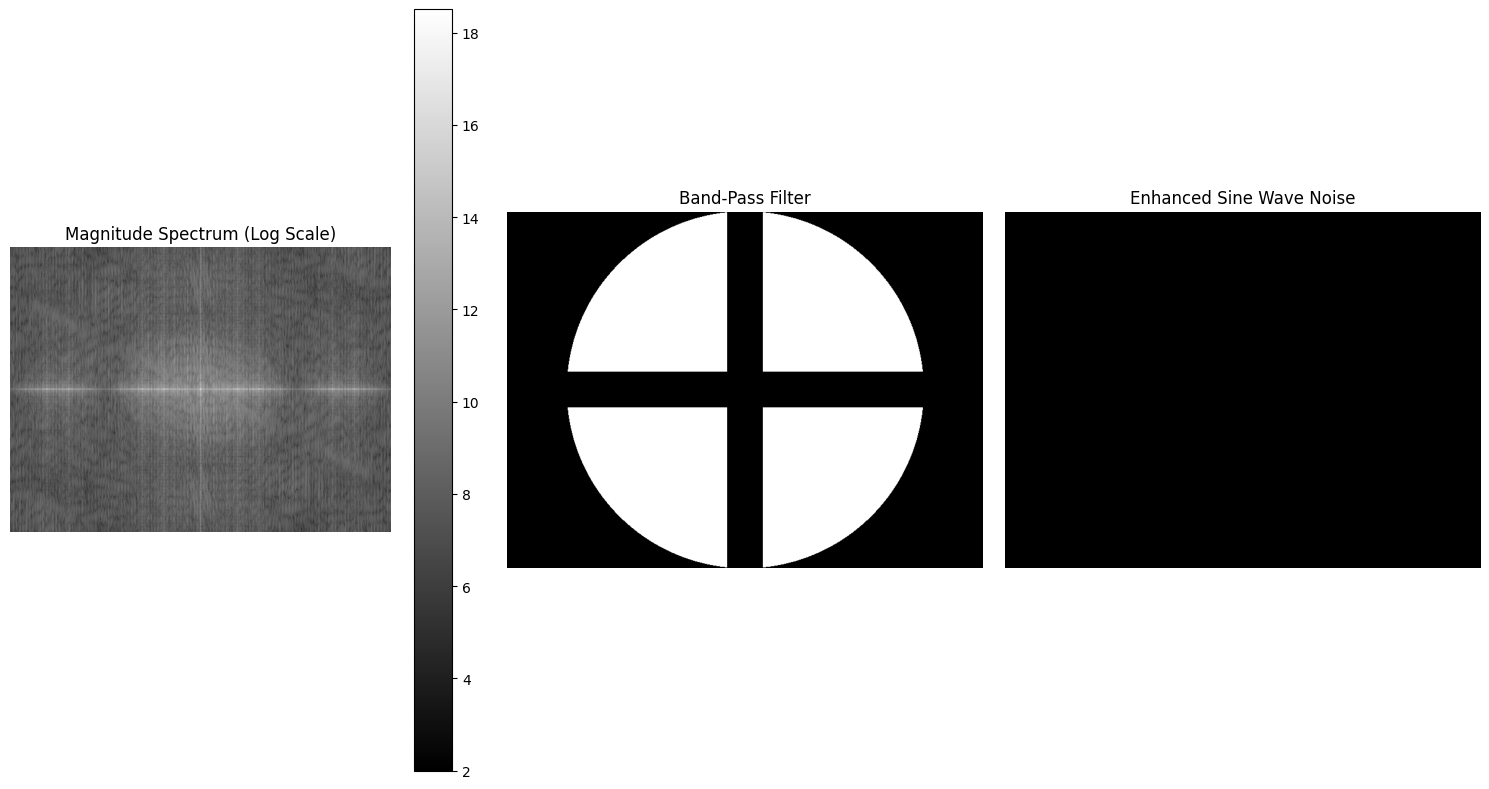

No noise sine waves detected.
['brightness']
0
0
0
0
0
0
0
0
0
0
0
0
----------------------------------
['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']
----------------------------------


Barcode decoded successfully
Processing 03 - eda ya3am ew3a soba3ak mathazarsh.jpg...
Min Intensity: 0, Max Intensity: 255, Contrast Range: 255
Contrast is within acceptable range. No adjustments needed.
Average brightness: 226.01009166666665
Brightness adjustment needed.


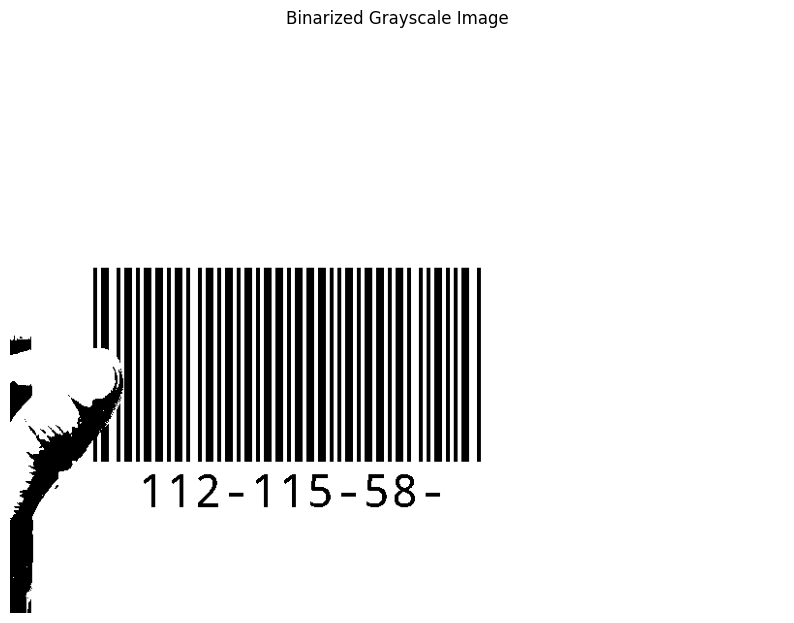

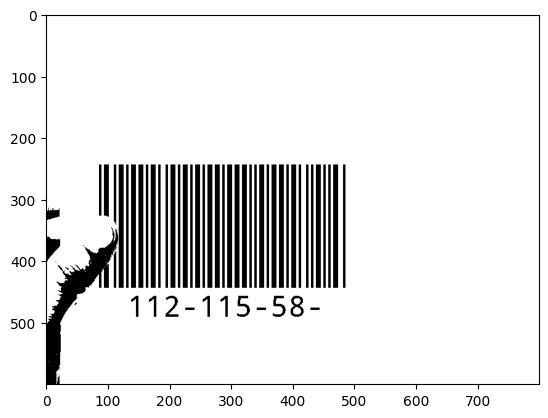

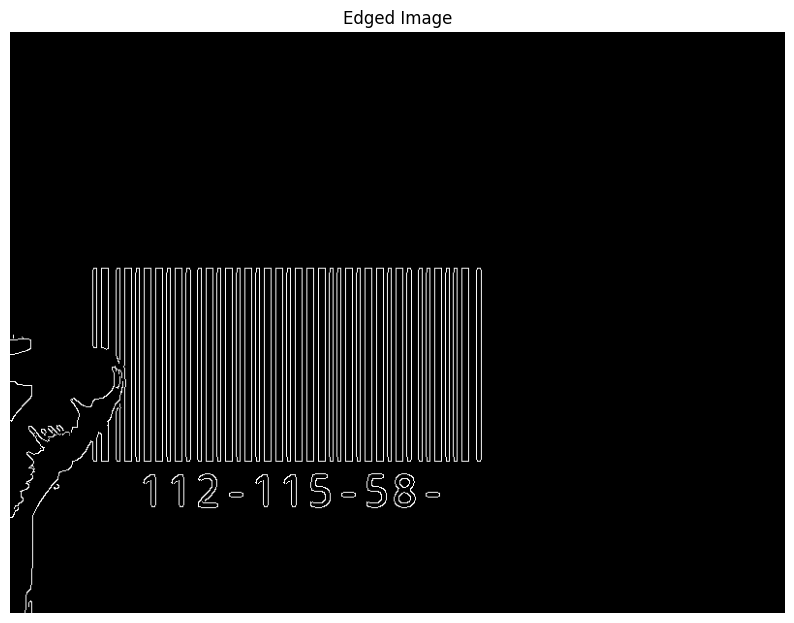

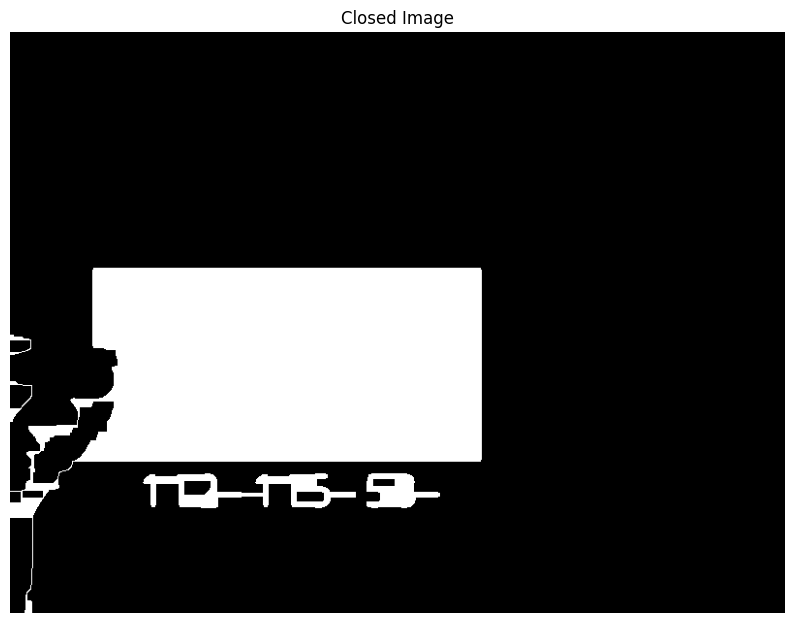

No barcode detected


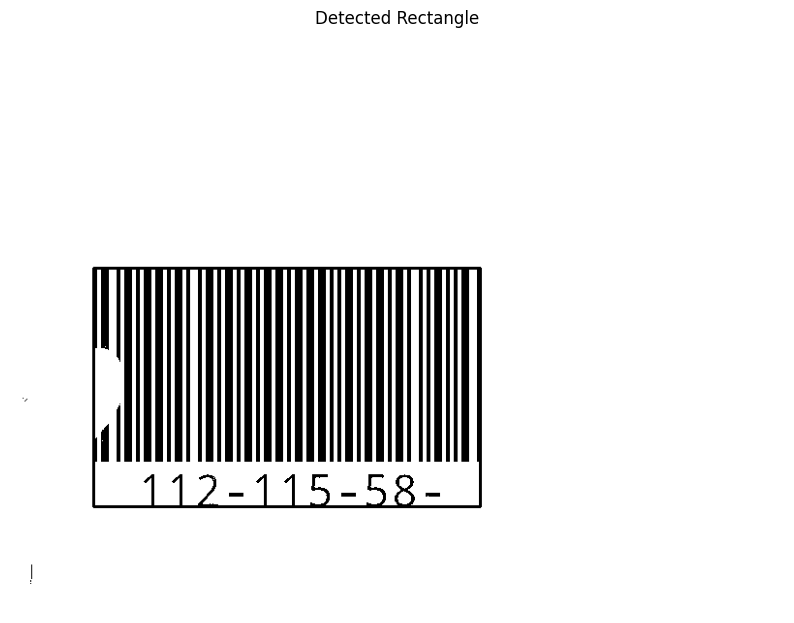

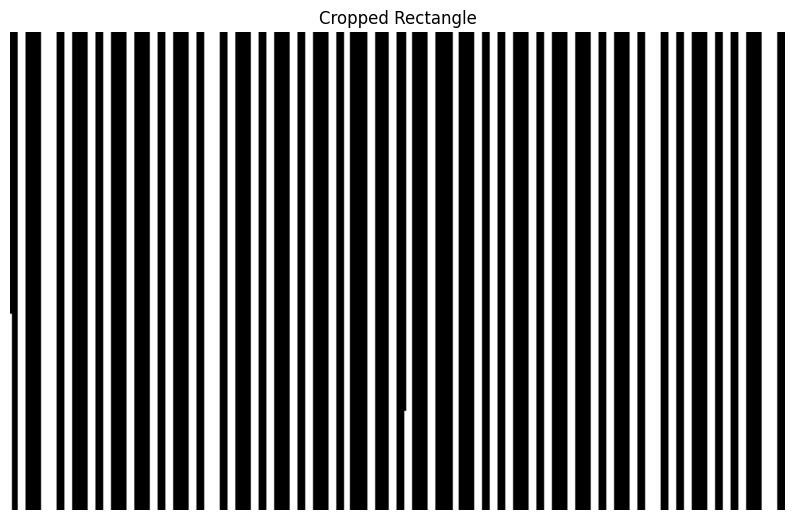

Cropped rectangle saved to output.jpg
['brightness']
0
0
0
0
0
0
0
0
0
0
0
0
----------------------------------
['Stop/Start', '1', '1', '2', '-', '1', '1', '5', '-', '5', '8', '-', 'Stop/Start']
----------------------------------


Barcode decoded successfully
Processing 04 - fen el nadara.jpg...
Min Intensity: 0, Max Intensity: 255, Contrast Range: 255
Contrast is within acceptable range. No adjustments needed.
Average brightness: 236.45330416666667
Brightness adjustment needed.


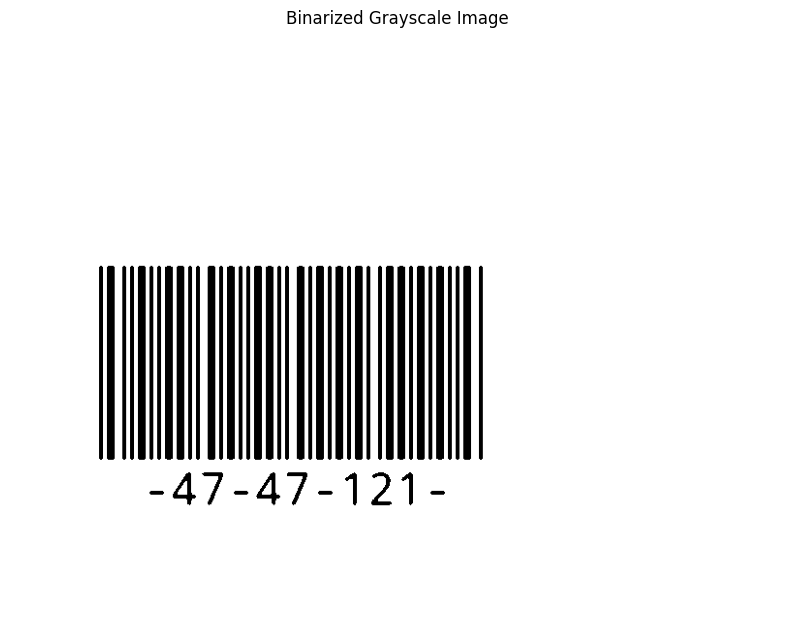

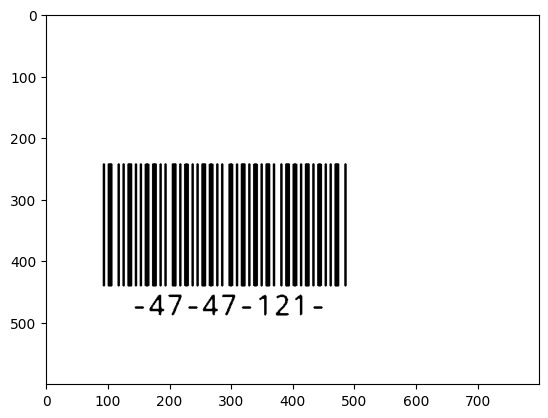

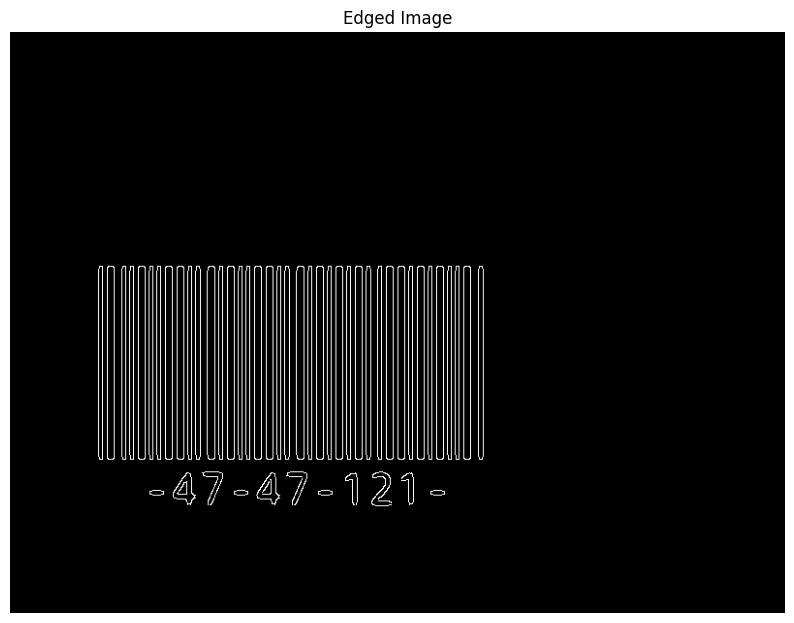

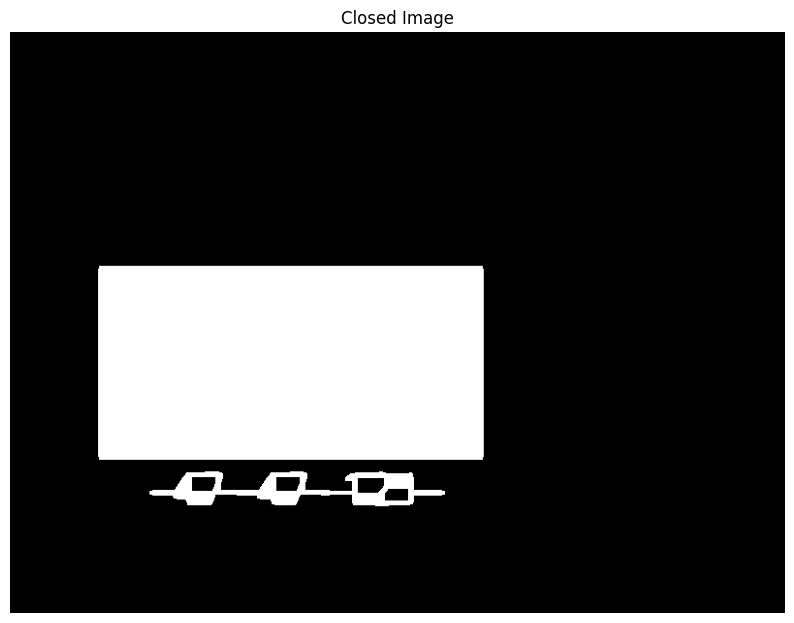

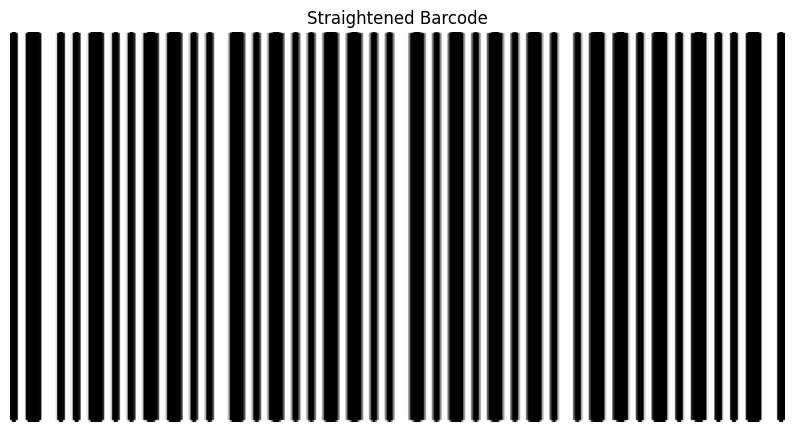

Straightened image saved to output.jpg


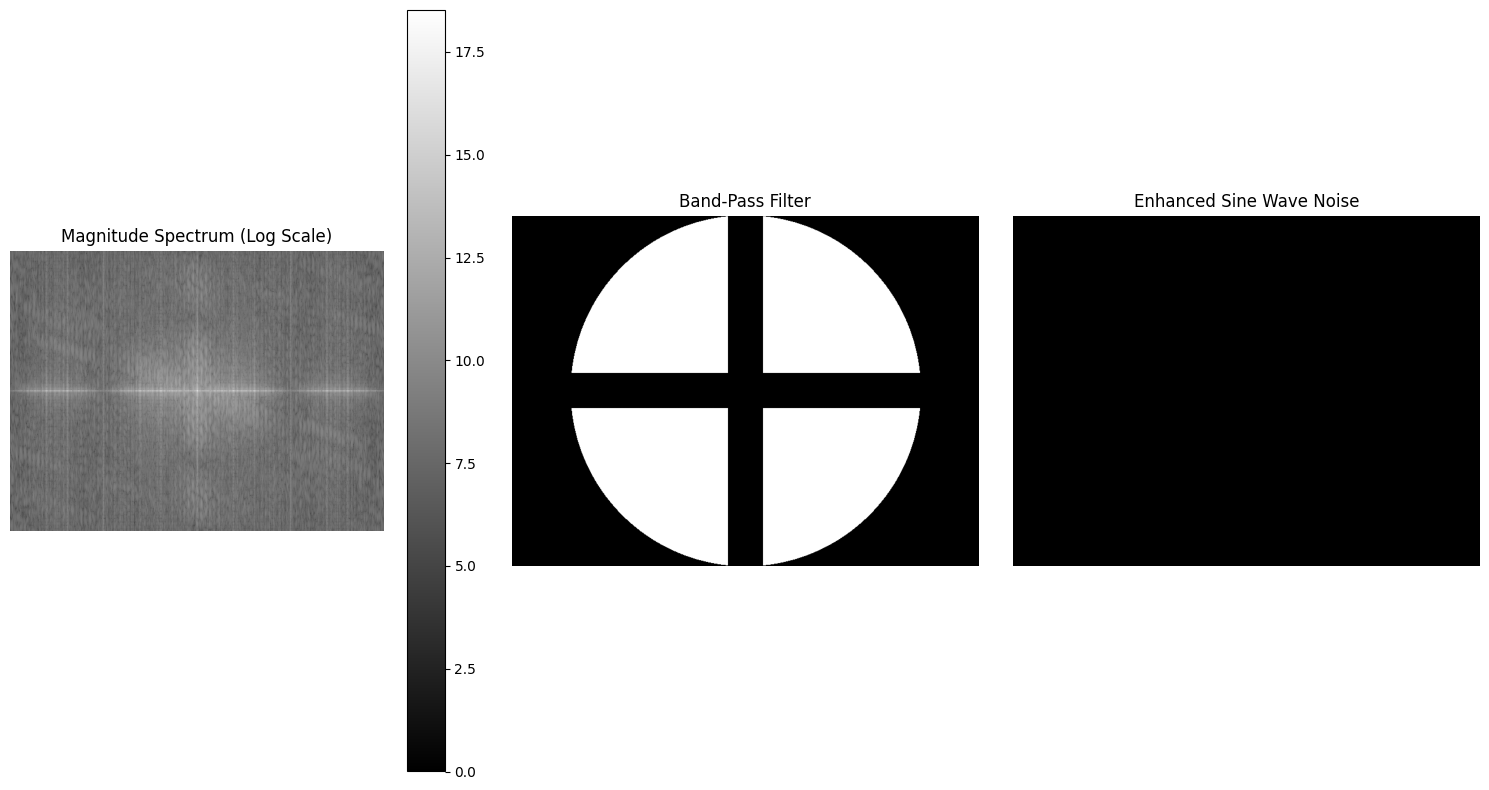

No noise sine waves detected.
['brightness']
0
0
0
0
0
0
0
0
0
0
0
0
----------------------------------
['Stop/Start', '-', '4', '7', '-', '4', '7', '-', '1', '2', '1', '-', 'Stop/Start']
----------------------------------


Barcode decoded successfully
Processing 05 - meen taffa el nour!!!.jpg...
Min Intensity: 0, Max Intensity: 21, Contrast Range: 21
Low contrast detected
Average brightness: 228.93315625
Brightness adjustment needed.


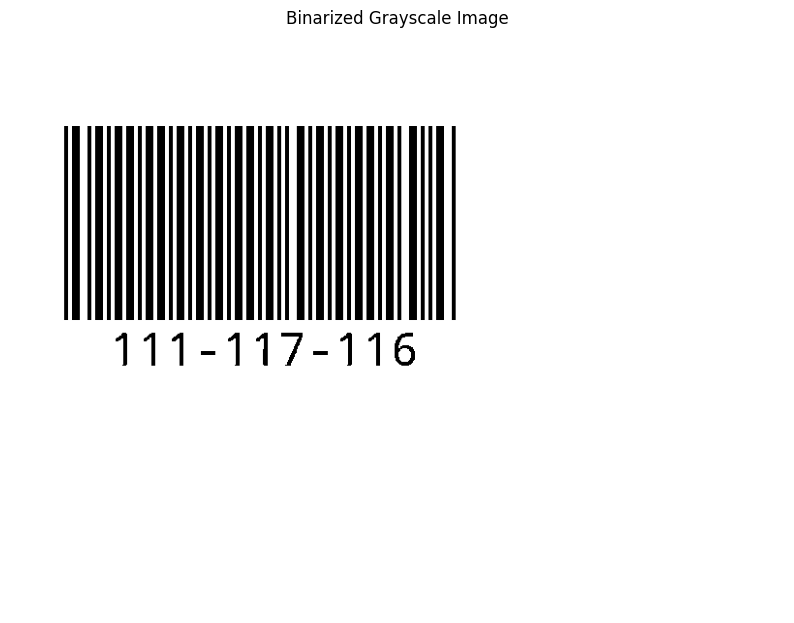

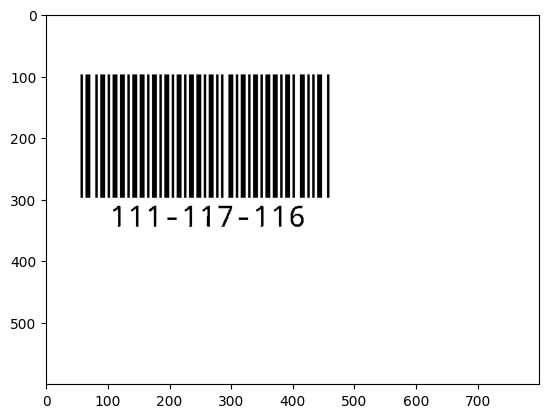

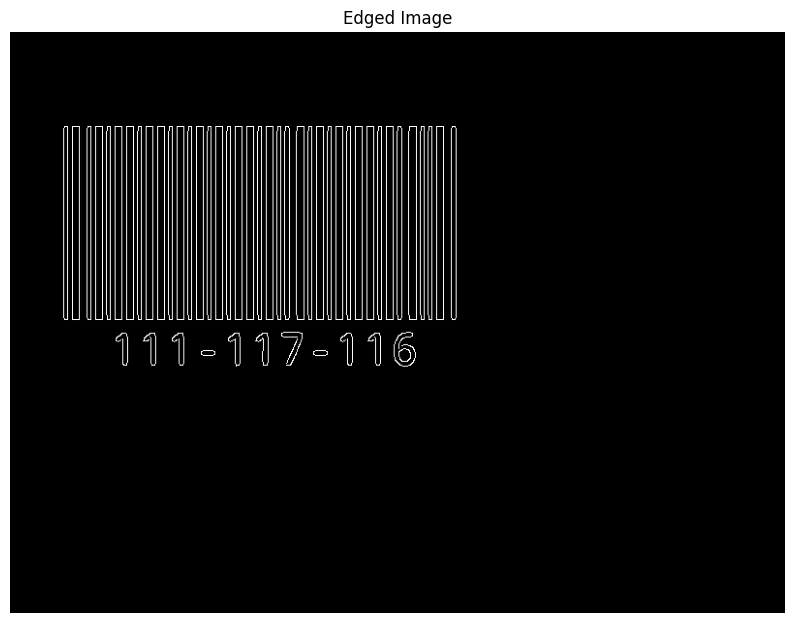

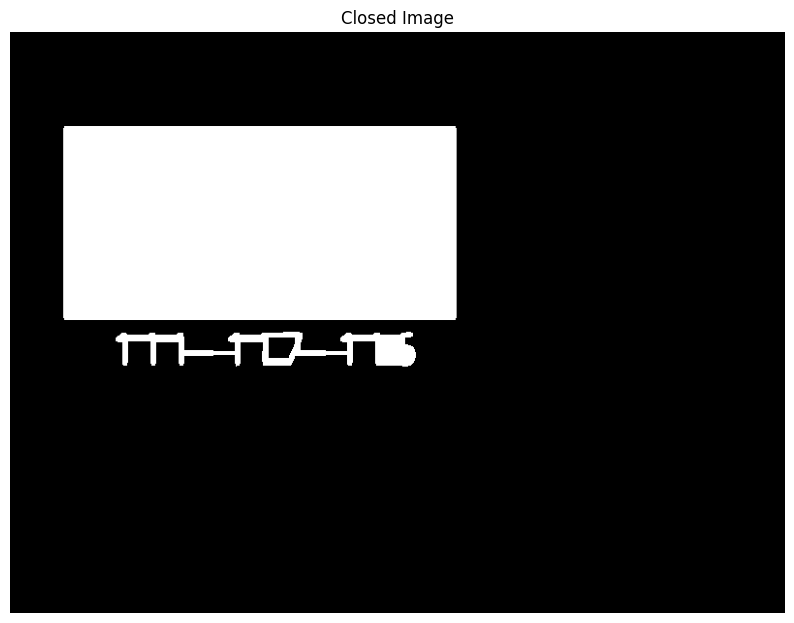

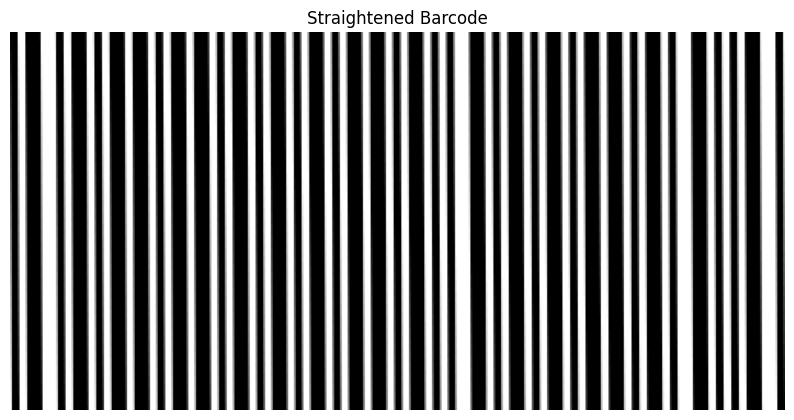

Straightened image saved to output.jpg


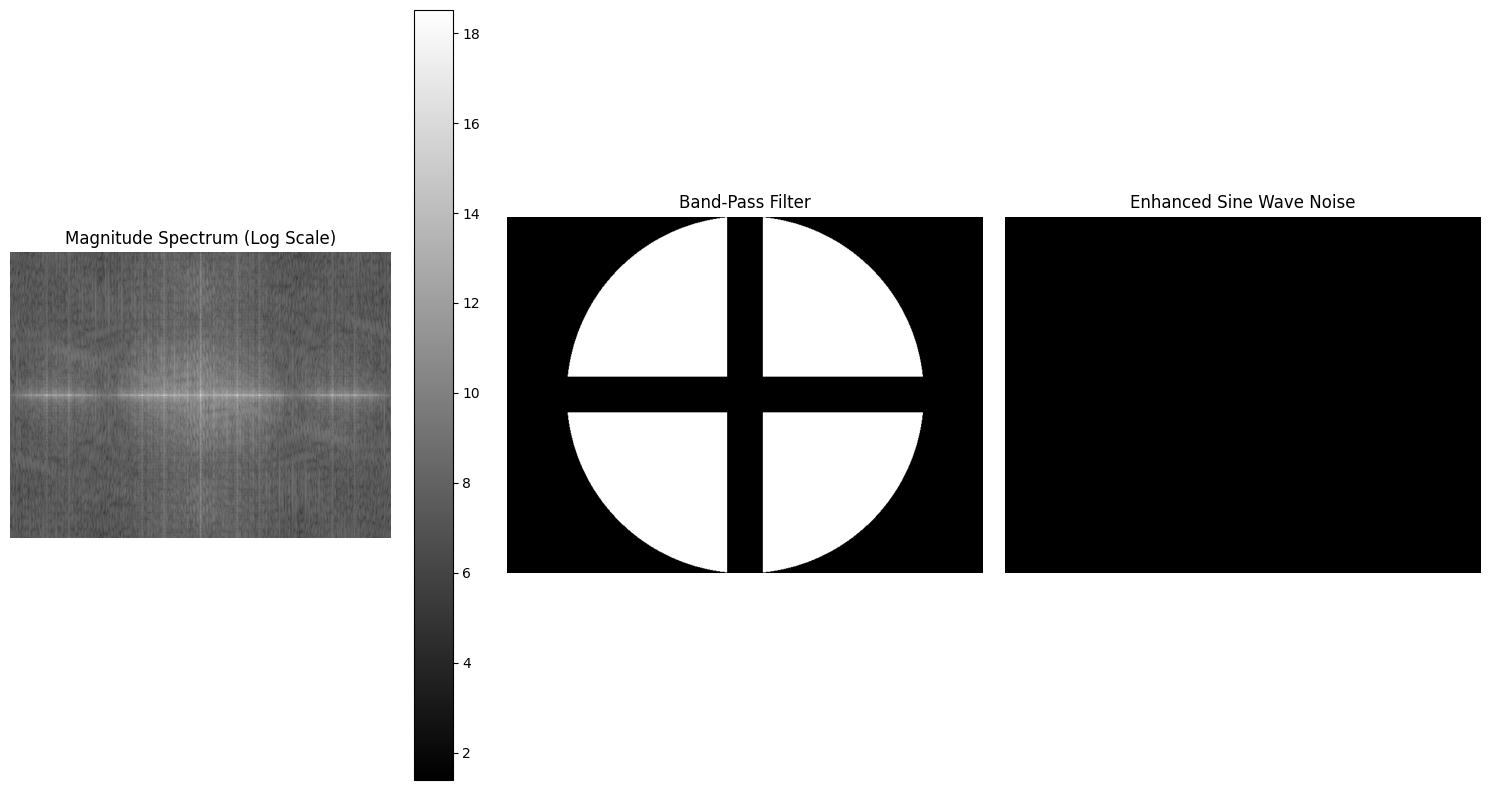

No noise sine waves detected.
['low_contrast', 'brightness']
0
0
0
0
0
0
0
0
0
0
0
0
----------------------------------
['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start']
----------------------------------


Barcode decoded successfully
Processing 06 - meen fata7 el nour 333eenaaayy.jpg...
Min Intensity: 236, Max Intensity: 255, Contrast Range: 19
Low contrast detected
Average brightness: 230.35425
Brightness adjustment needed.


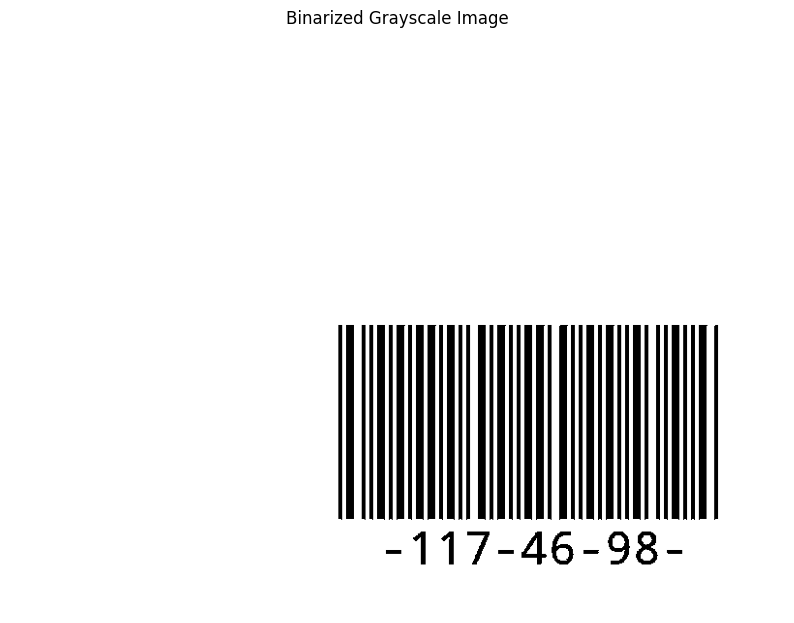

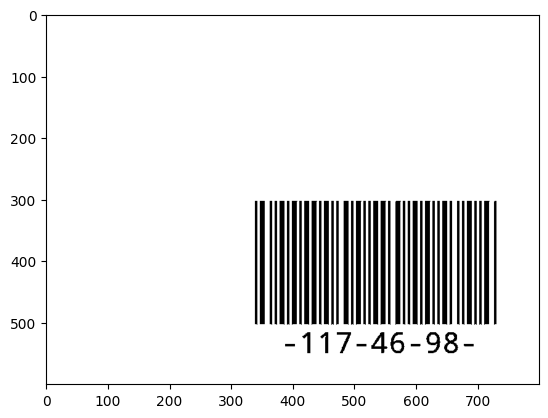

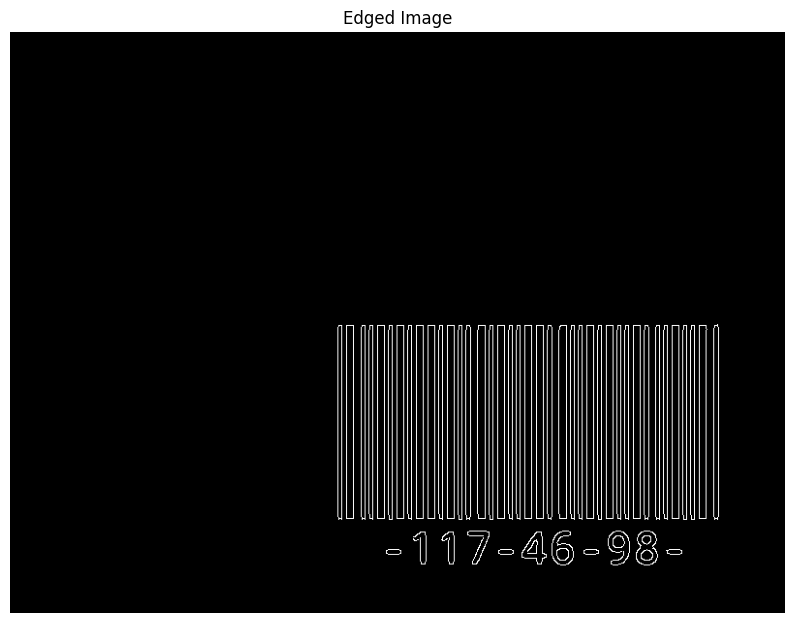

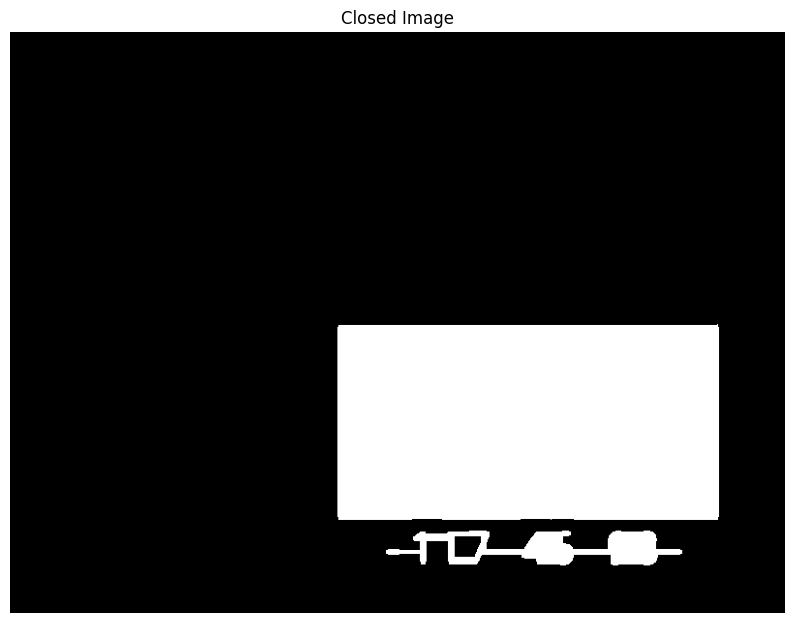

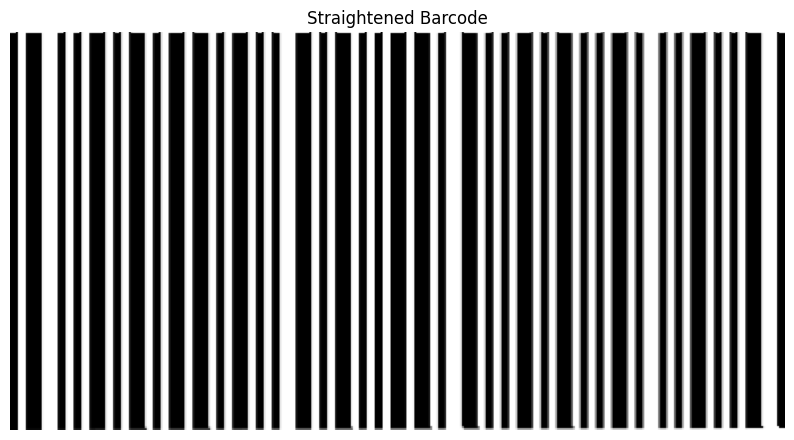

Straightened image saved to output.jpg


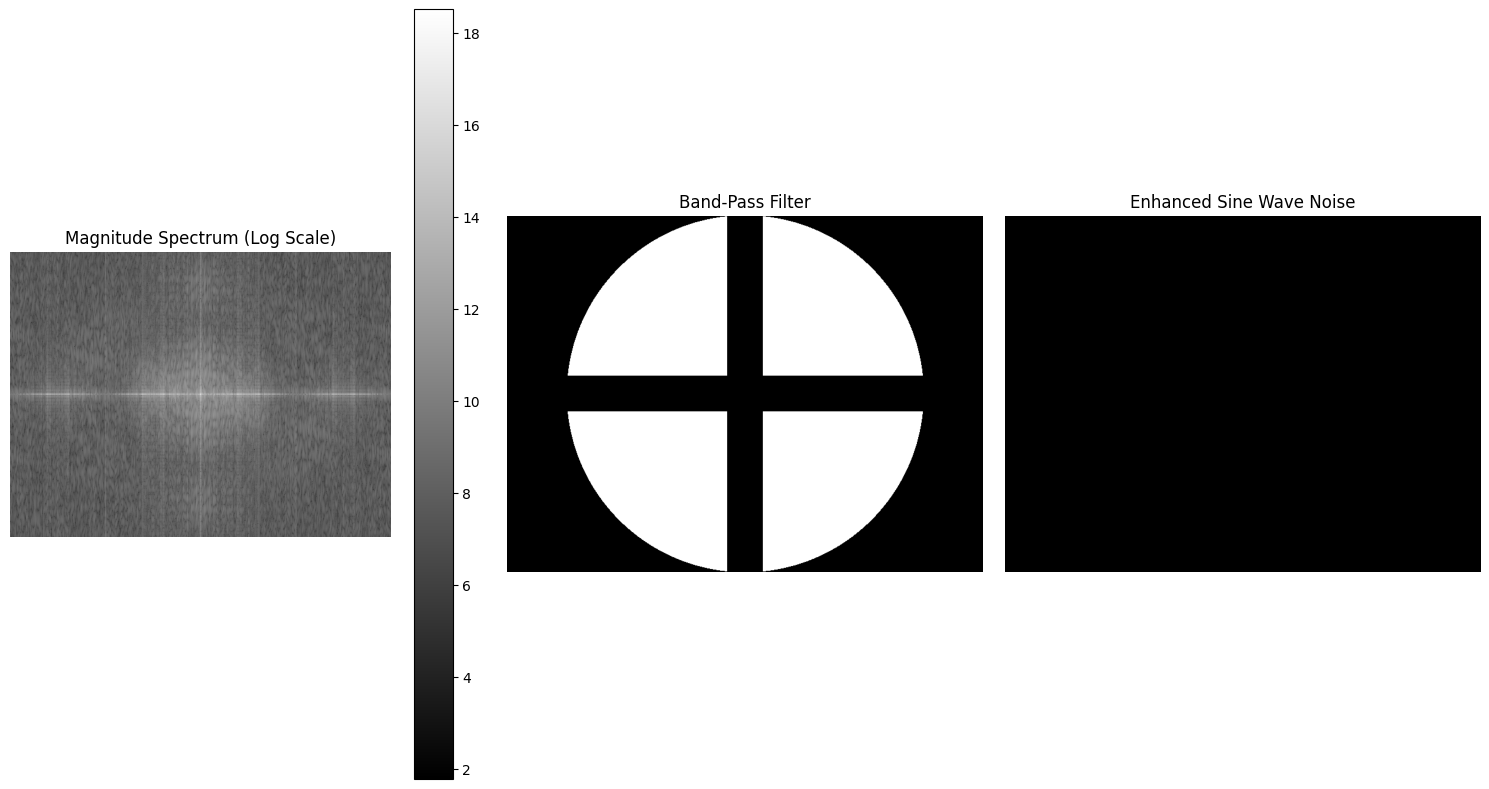

No noise sine waves detected.
['low_contrast', 'brightness']
0
0
0
0
0
0
0
0
0
0
0
0
----------------------------------
['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start']
----------------------------------


Barcode decoded successfully
Processing 07 - mal7 w felfel.jpg...
Min Intensity: 0, Max Intensity: 255, Contrast Range: 255
Contrast is within acceptable range. No adjustments needed.
Average brightness: 229.82459375
Brightness adjustment needed.


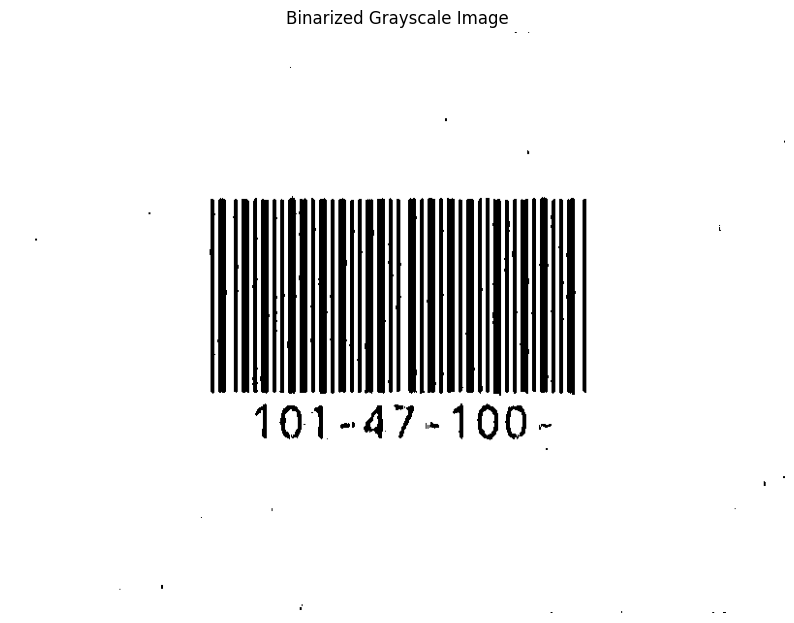

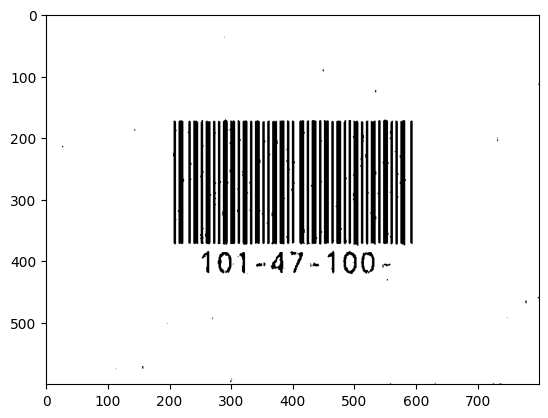

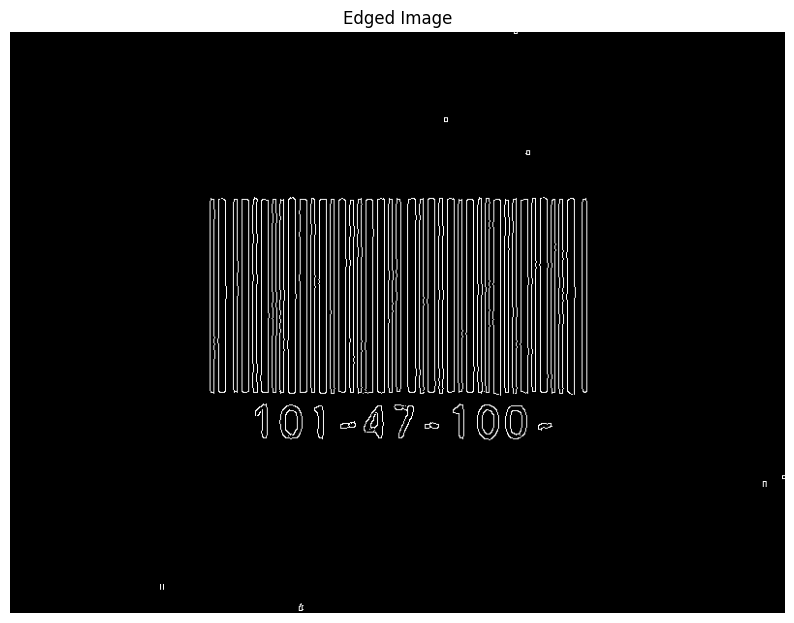

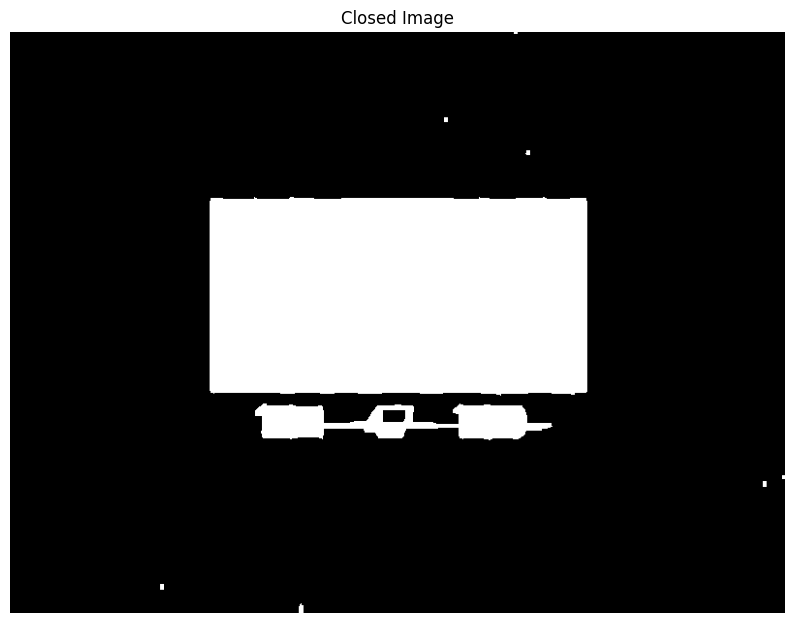

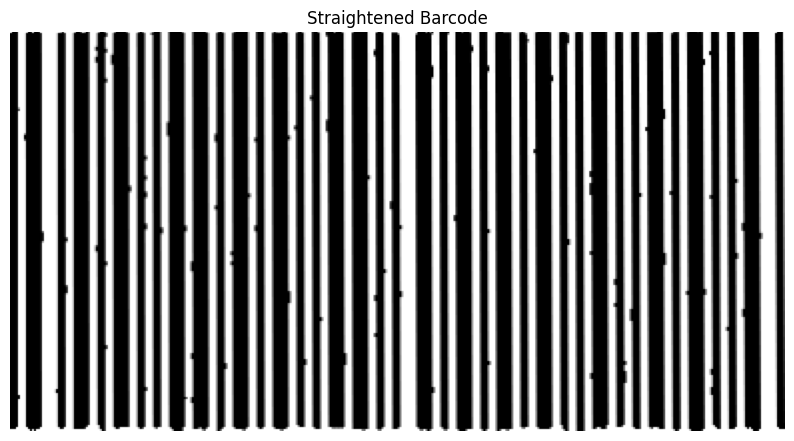

Straightened image saved to output.jpg


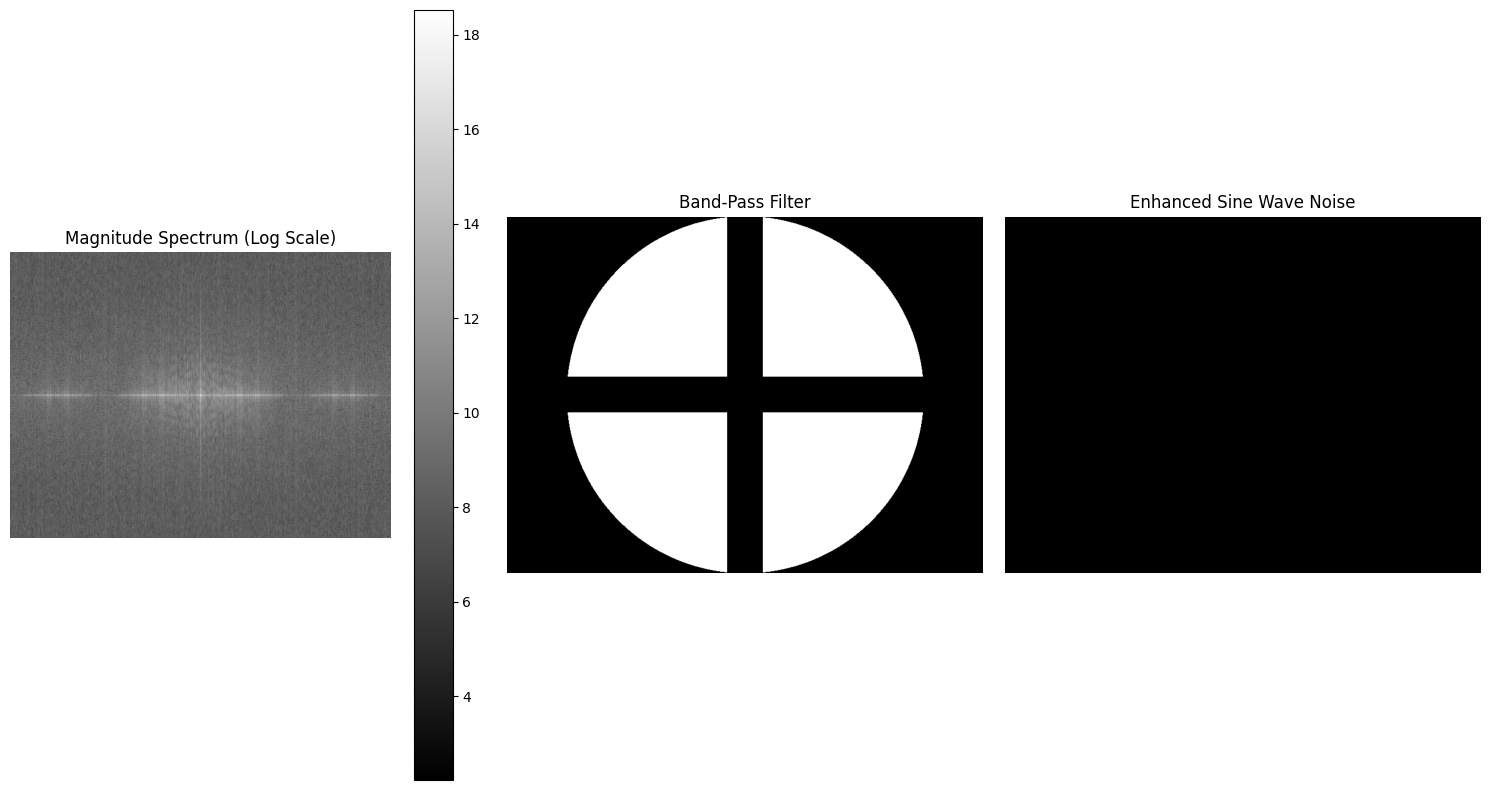

No noise sine waves detected.
['salt_pepper', 'brightness']
0
0
0
0
0
0
0
0
0
0
0
0
0
----------------------------------
['Stop/Start', '1', '0', '1', '-', '4', '7', '-', '1', '0', '0', '-', 'Stop/Start']
----------------------------------


Barcode decoded successfully
Processing 08 - compresso espresso.jpg...
Min Intensity: 18, Max Intensity: 255, Contrast Range: 237
Contrast is within acceptable range. No adjustments needed.
Average brightness: 196.08360416666667
Brightness adjustment needed.


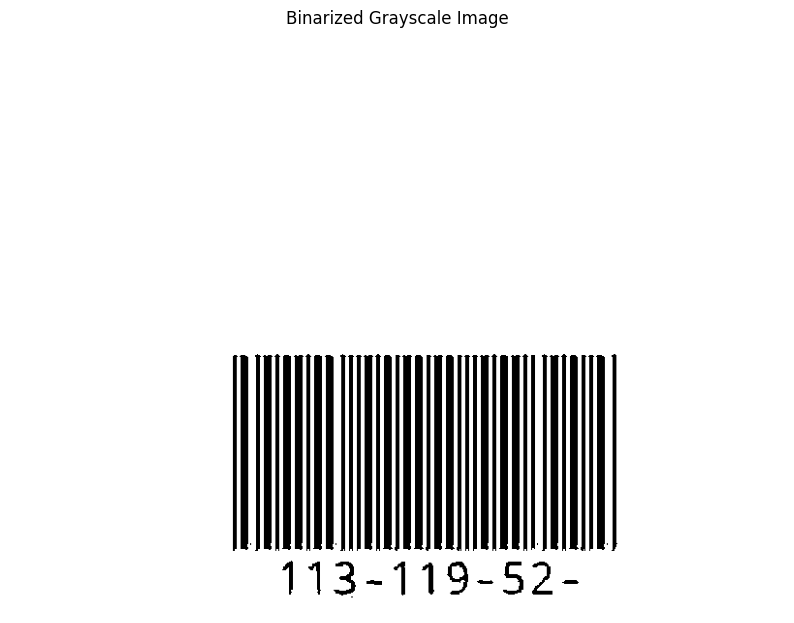

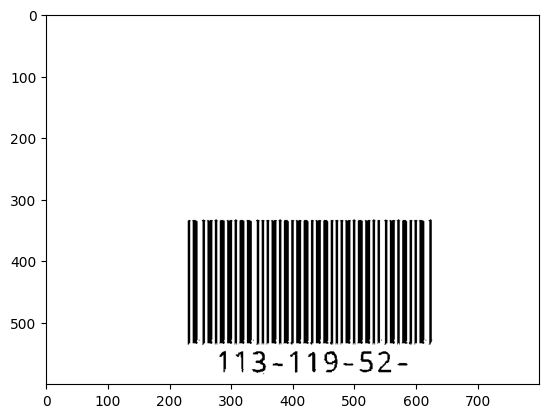

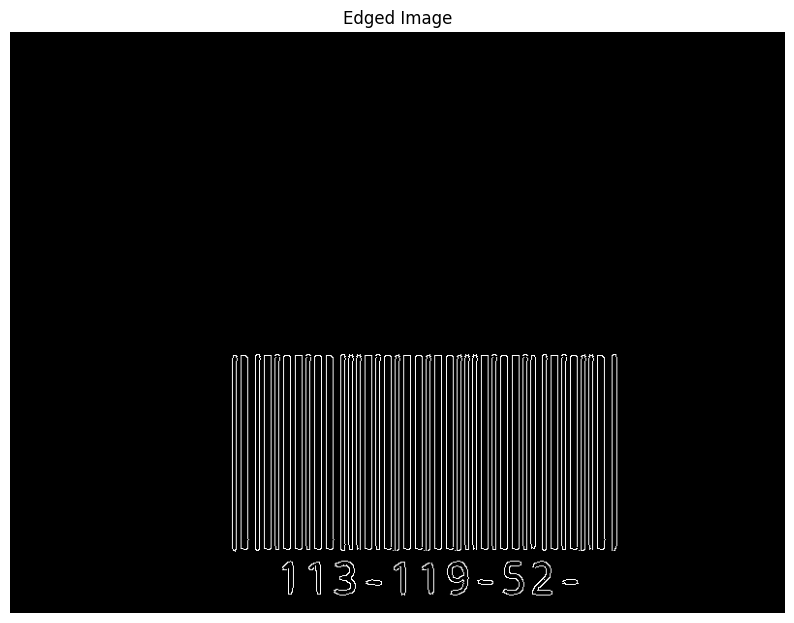

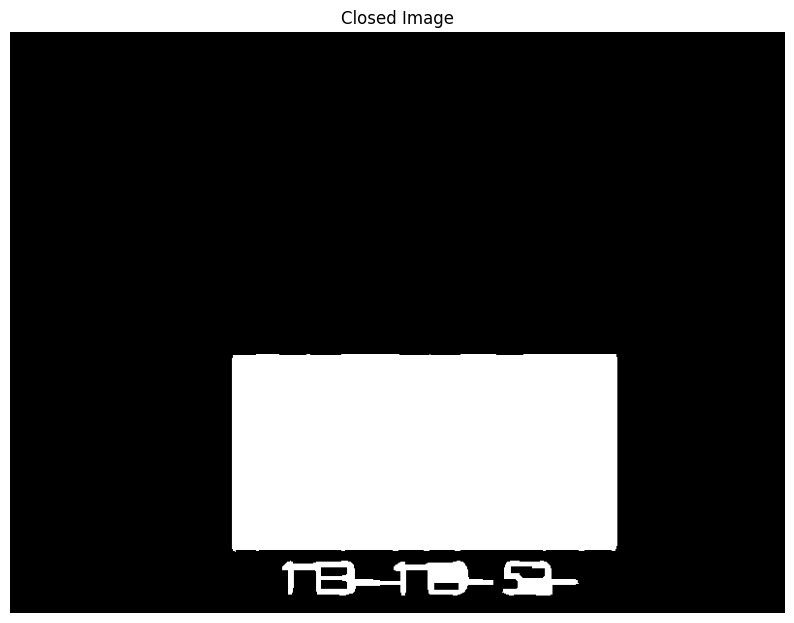

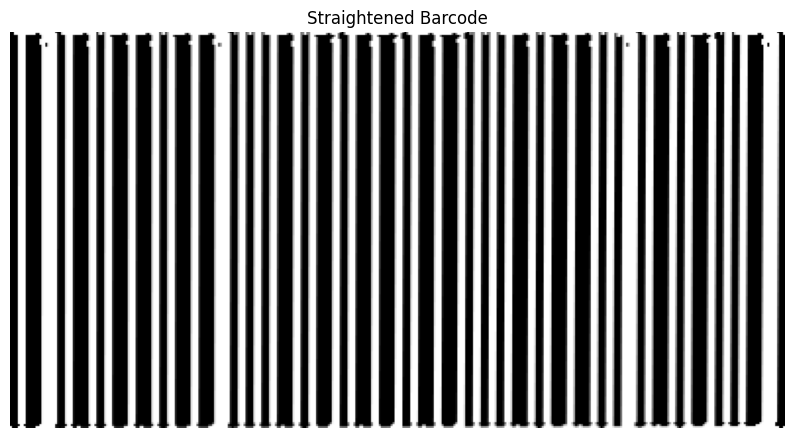

Straightened image saved to output.jpg


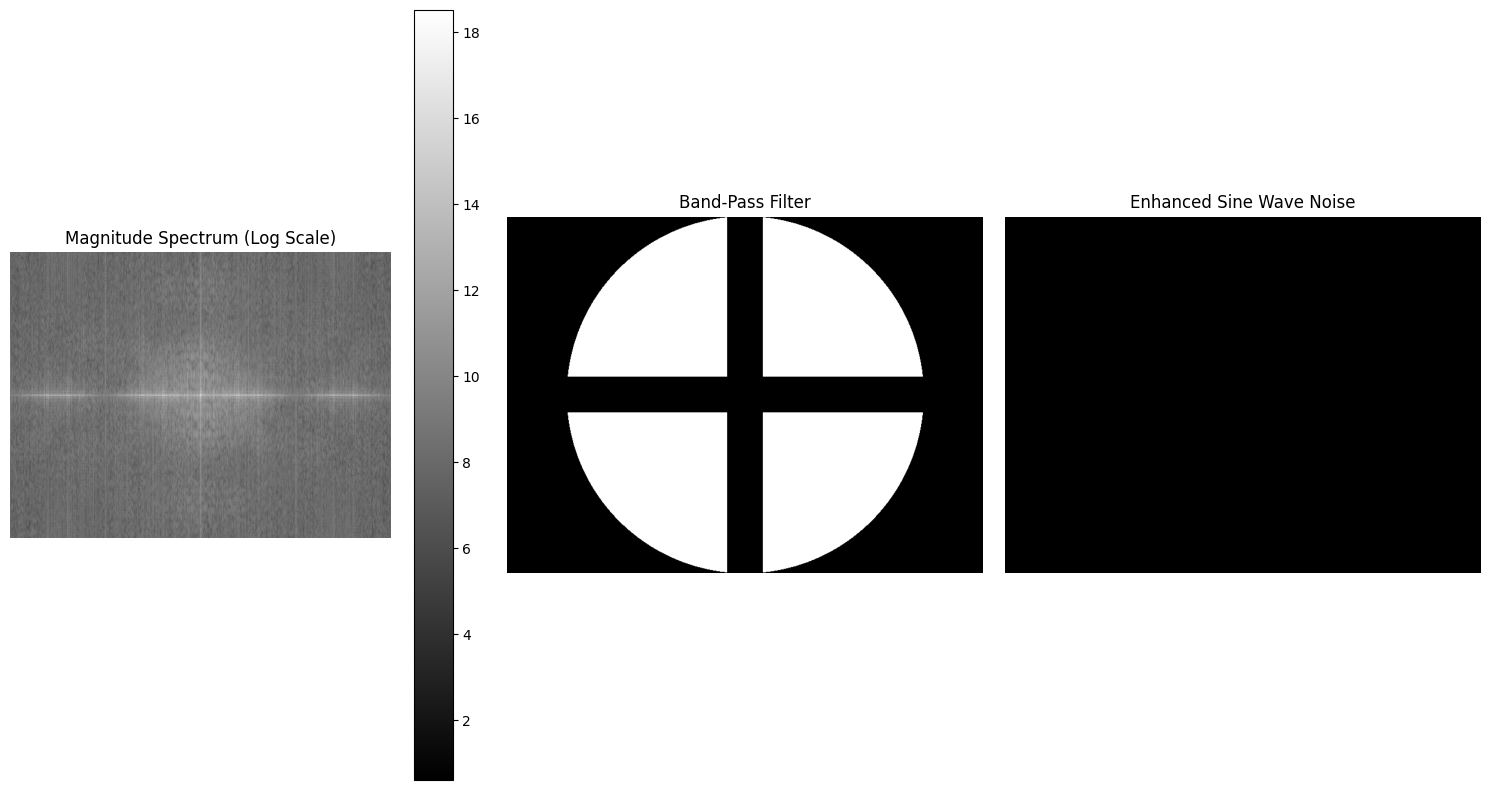

No noise sine waves detected.
['brightness']
0
0
0
0
0
0
0
0
0
0
0
0
----------------------------------
['Stop/Start', '1', '1', '3', '-', '1', '1', '9', '-', '5', '2', '-', 'Stop/Start']
----------------------------------


Barcode decoded successfully
Processing 09 - e3del el soora ya3ammm.jpg...
Min Intensity: 0, Max Intensity: 255, Contrast Range: 255
Contrast is within acceptable range. No adjustments needed.
Average brightness: 225.7679375
Brightness adjustment needed.


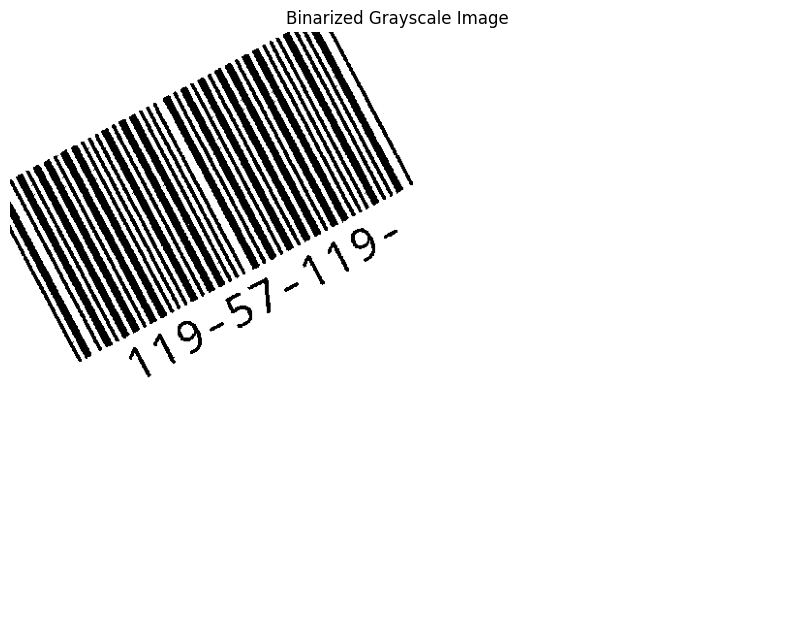

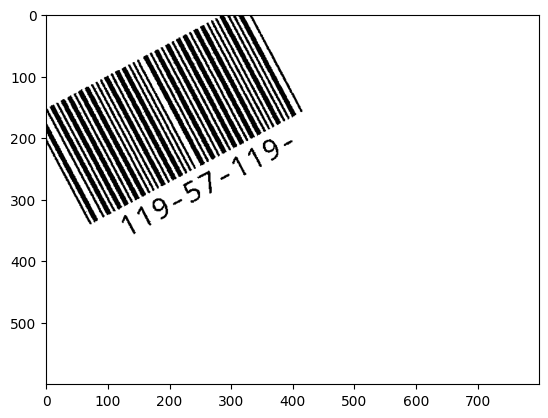

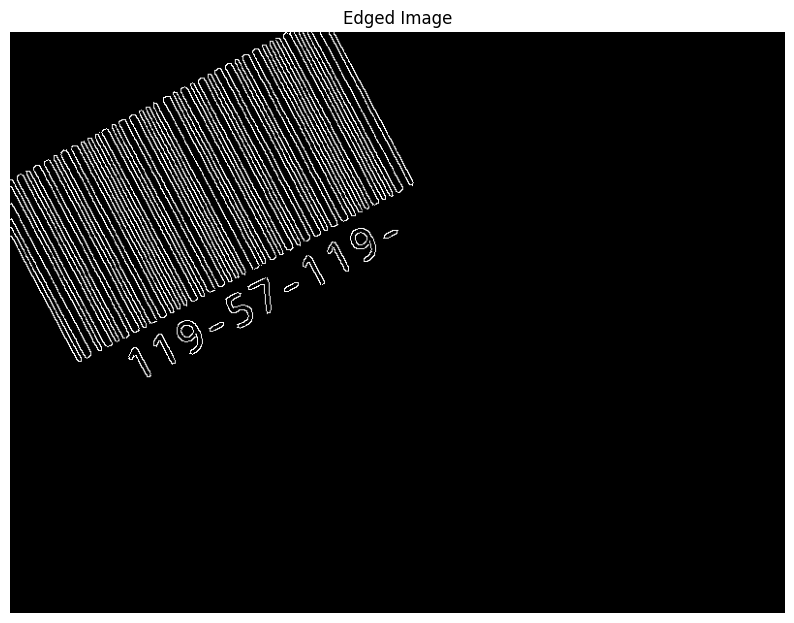

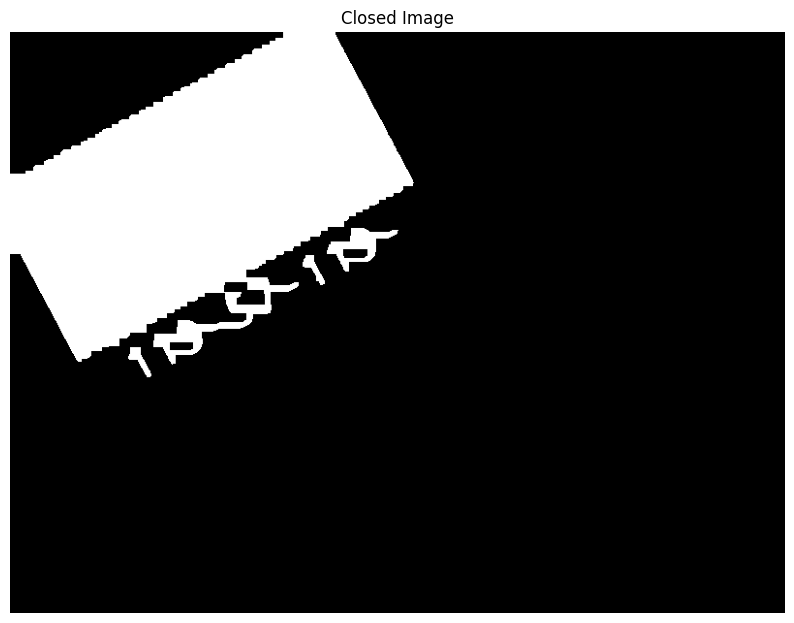

No barcode detected


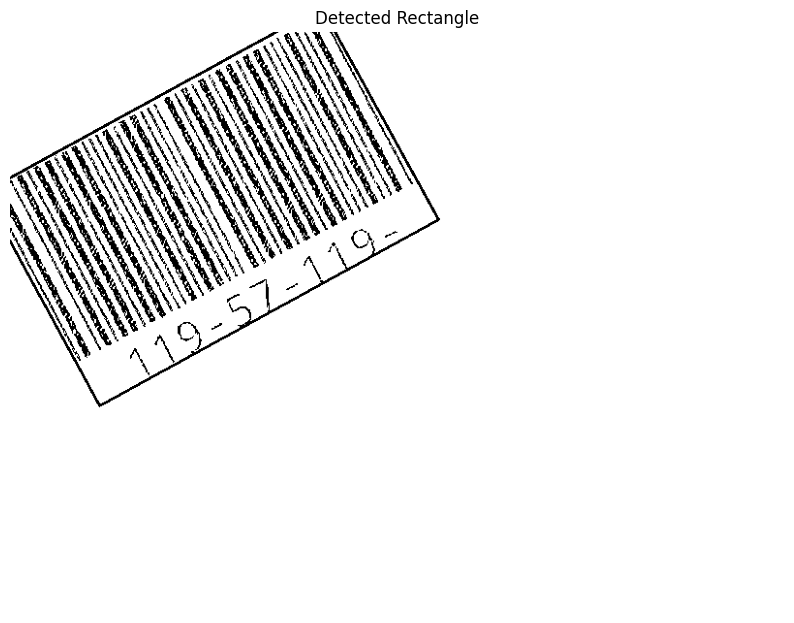

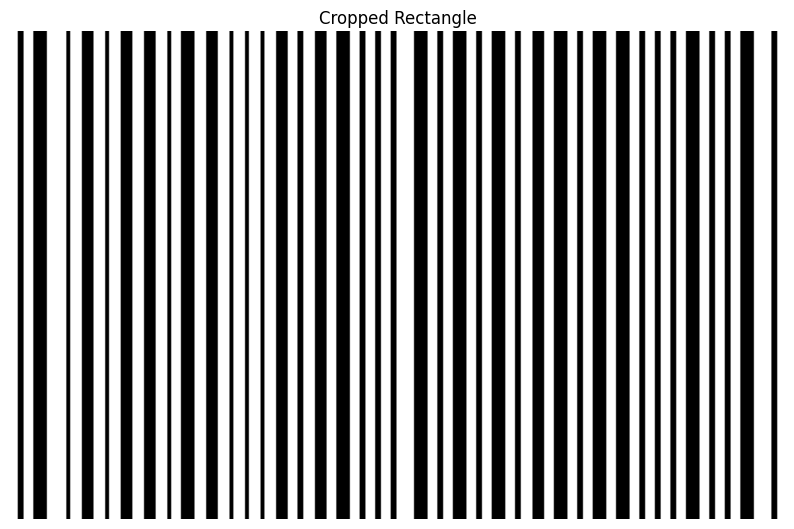

Cropped rectangle saved to output.jpg
['brightness']
0
Image loaded successfully.
0
0
0
0
0
0
0
0
0
0
0
0
----------------------------------
['Stop/Start', '1', '1', '9', '-', '5', '7', '-', '1', '1', '9', '-', 'Stop/Start']
----------------------------------


Processing 10 - wen el kontraastttt.jpg...
Min Intensity: 120, Max Intensity: 131, Contrast Range: 11
Low contrast detected
Average brightness: 230.60075
Brightness adjustment needed.


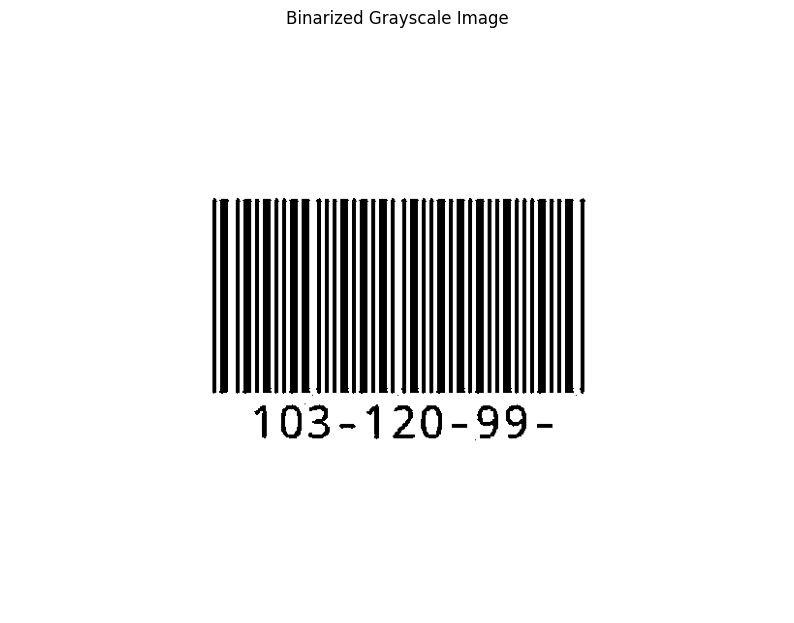

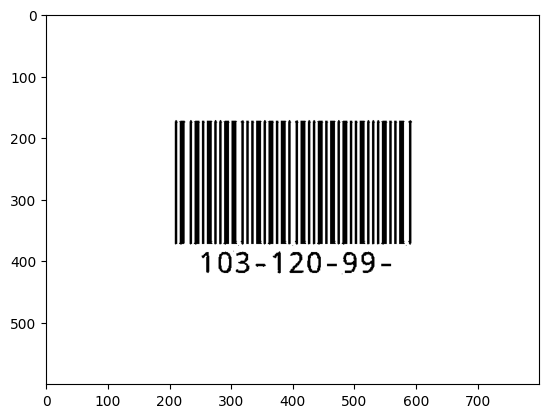

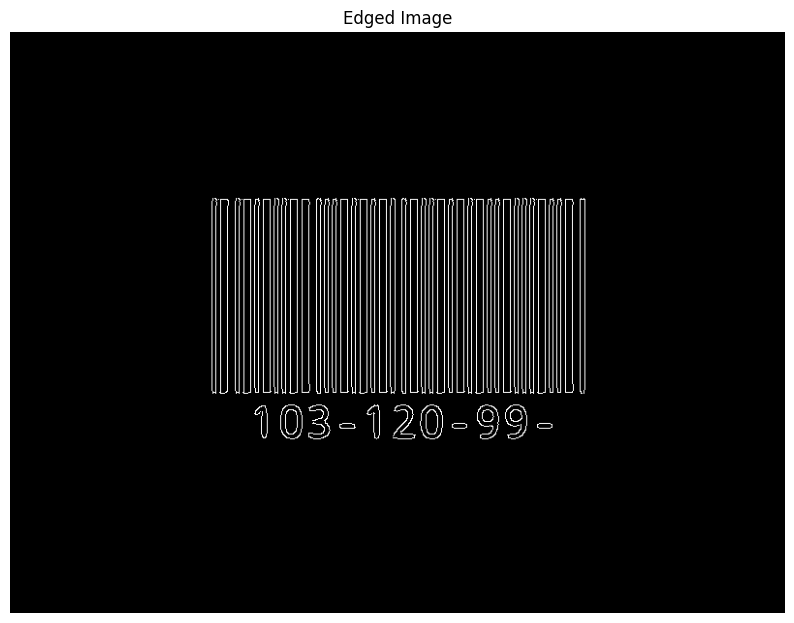

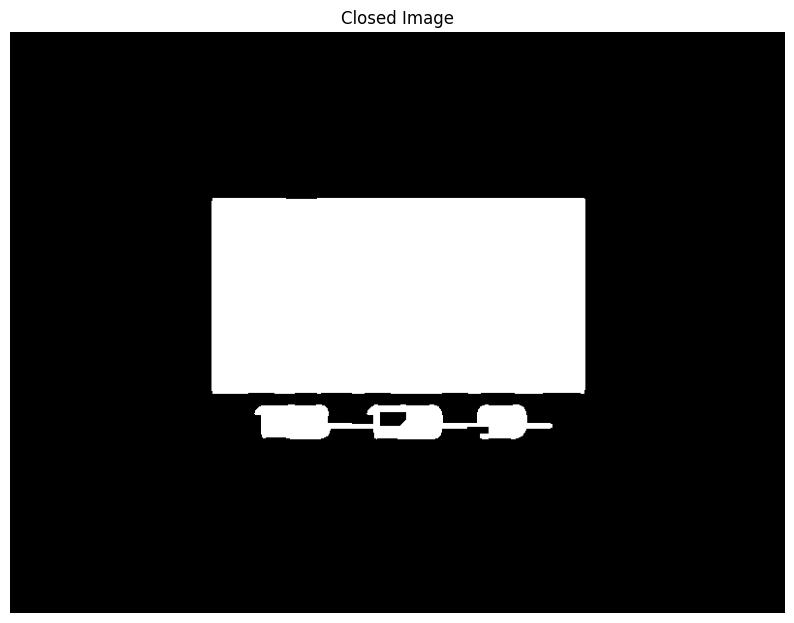

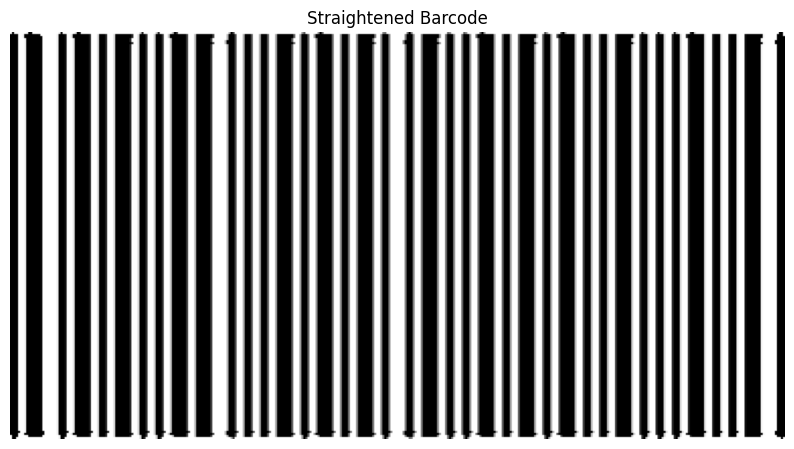

Straightened image saved to output.jpg


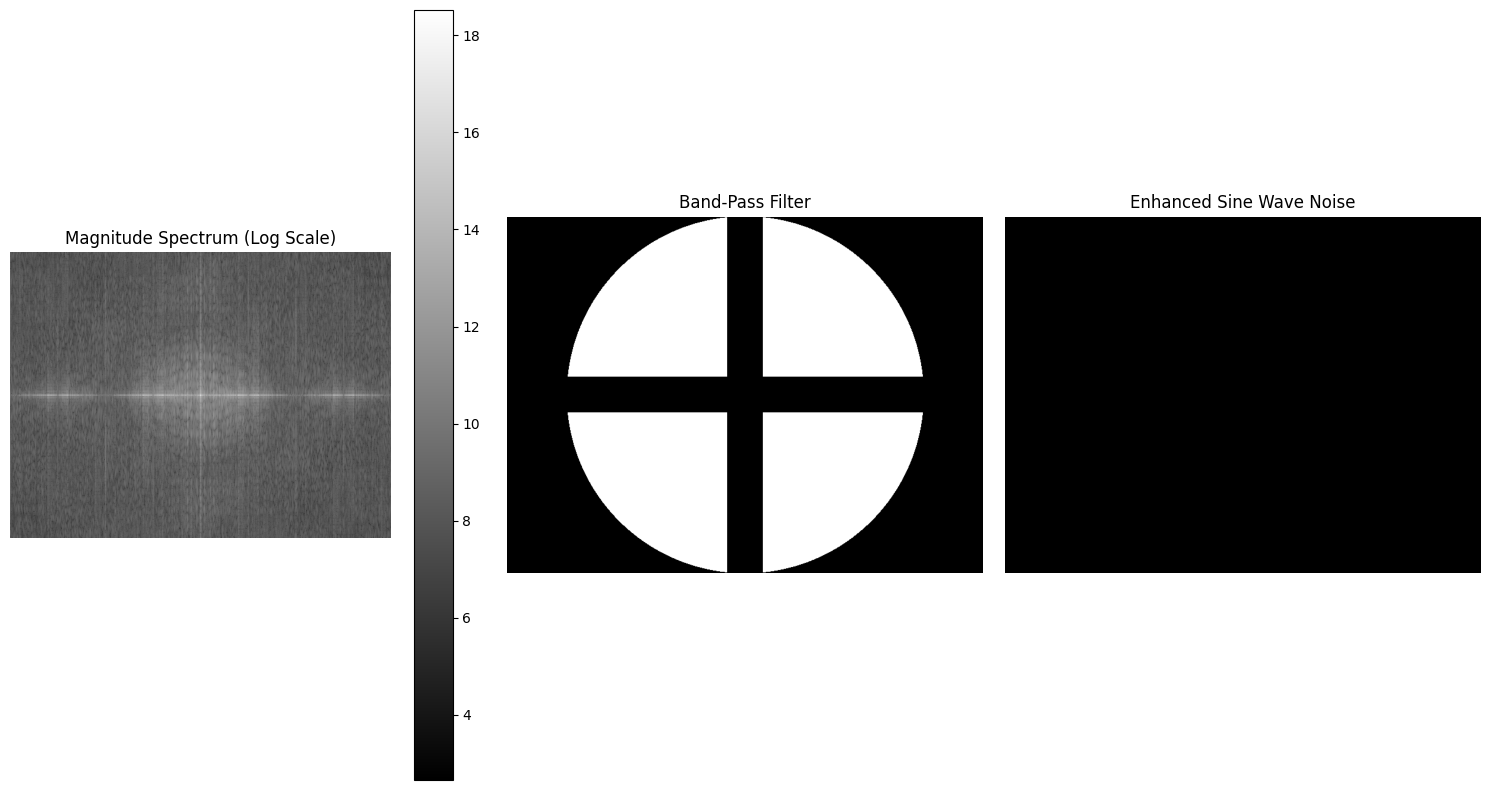

No noise sine waves detected.
['low_contrast', 'brightness']
0
0
0
0
0
0
0
0
0
0
0
0
----------------------------------
['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']
----------------------------------


Barcode decoded successfully
Processing 11 - bayza 5ales di bsara7a.jpg...
Min Intensity: 0, Max Intensity: 255, Contrast Range: 255
Contrast is within acceptable range. No adjustments needed.
Average brightness: 170.33564166666667
Brightness is within acceptable range.


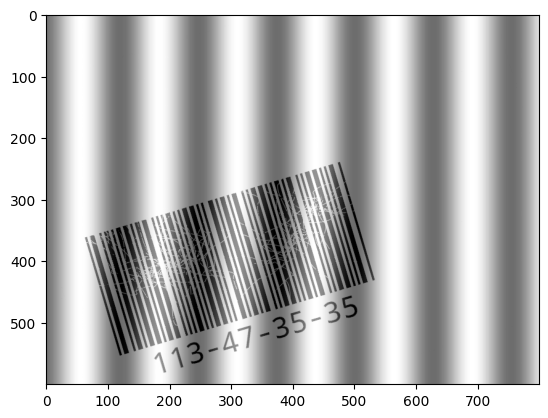

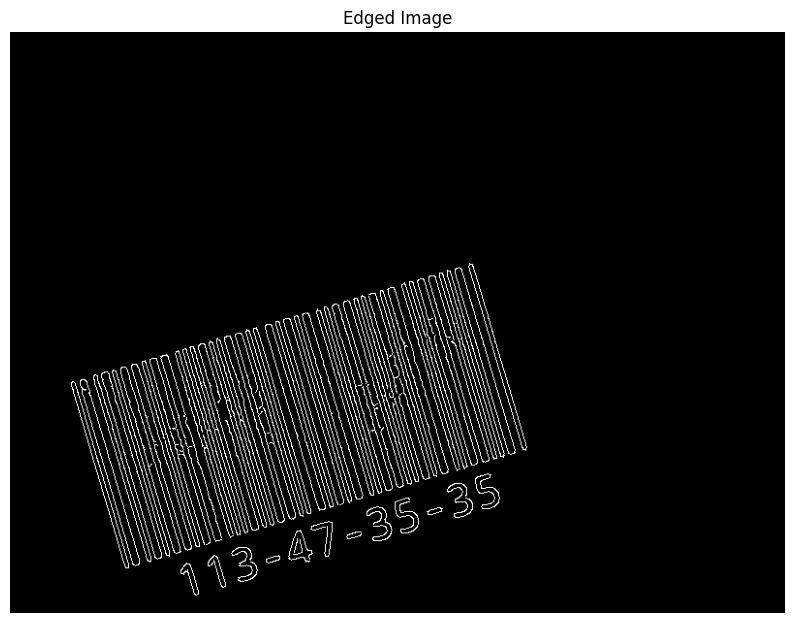

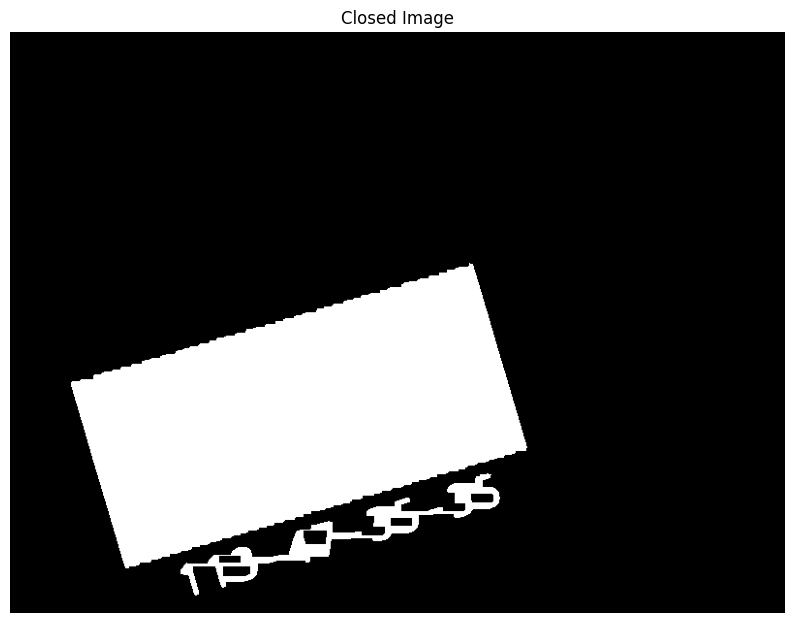

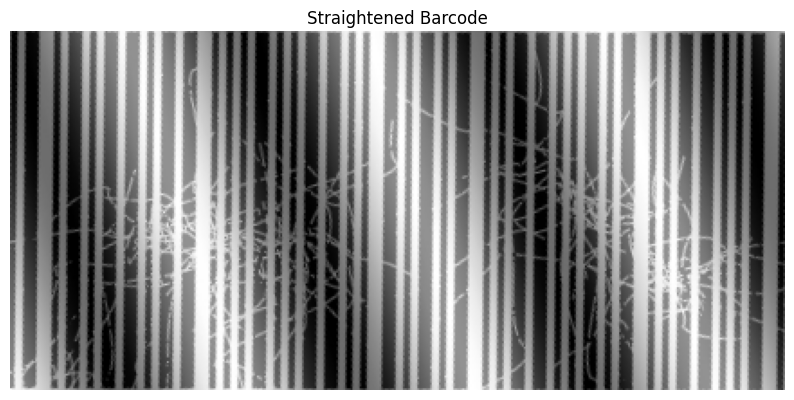

Straightened image saved to output.jpg


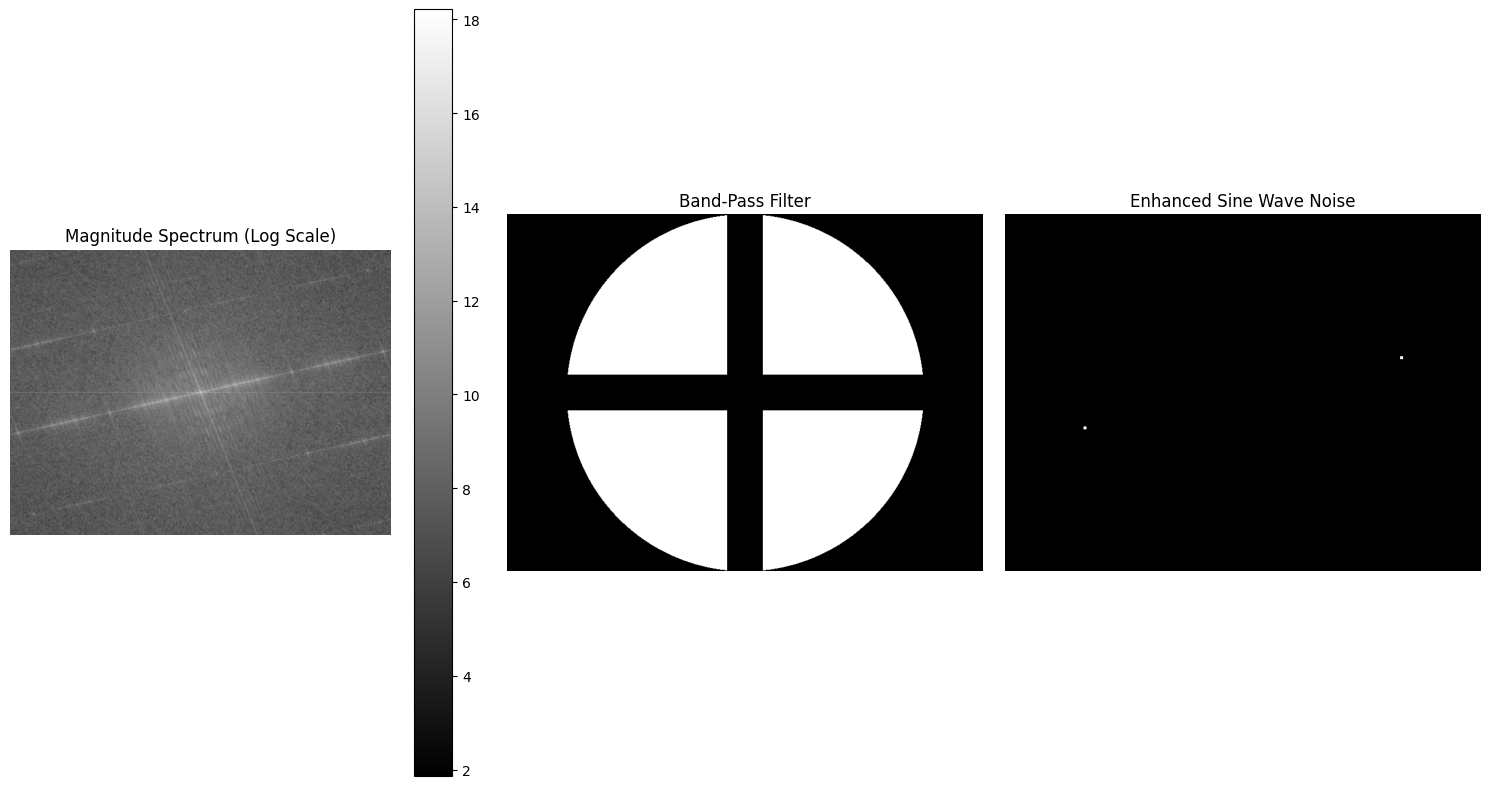

Noise sine waves detected.


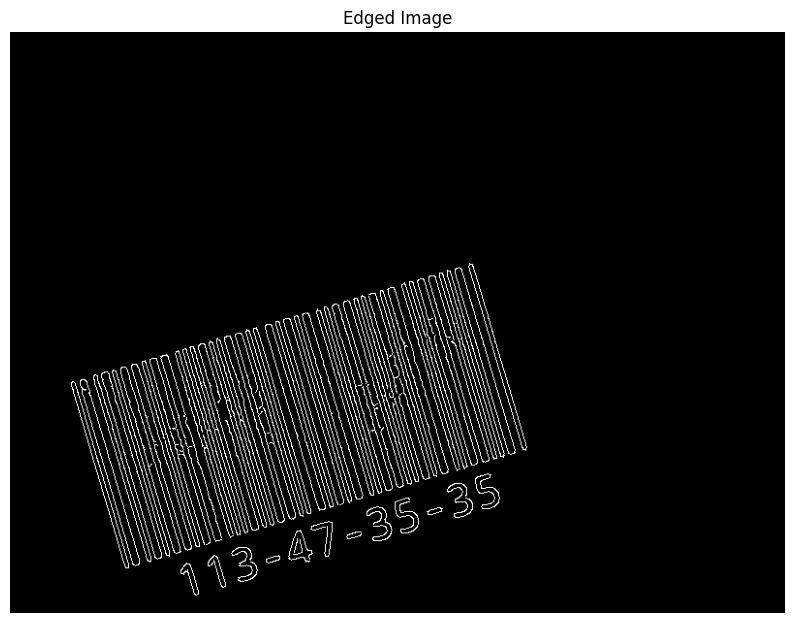

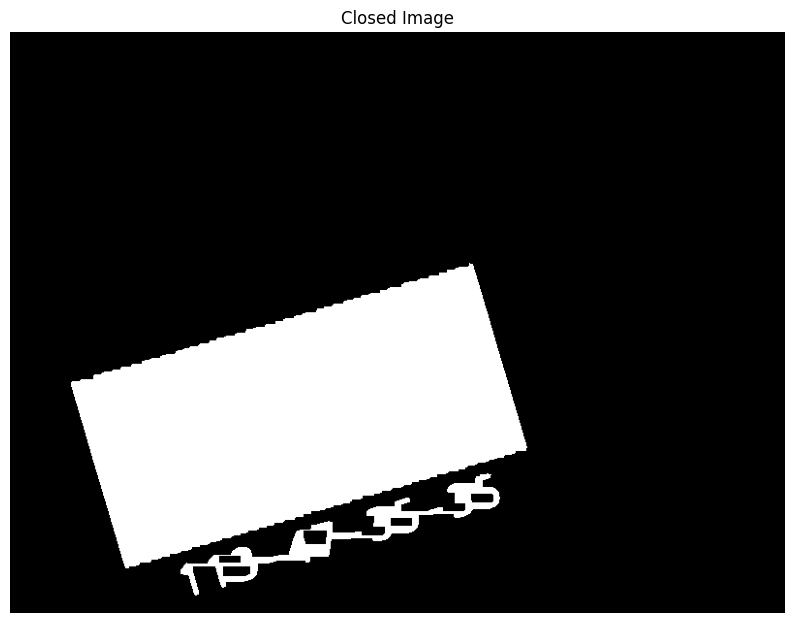

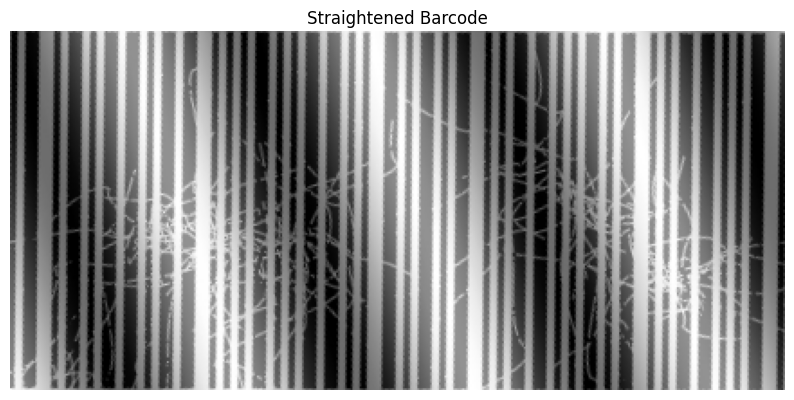

Straightened image saved to output.jpg


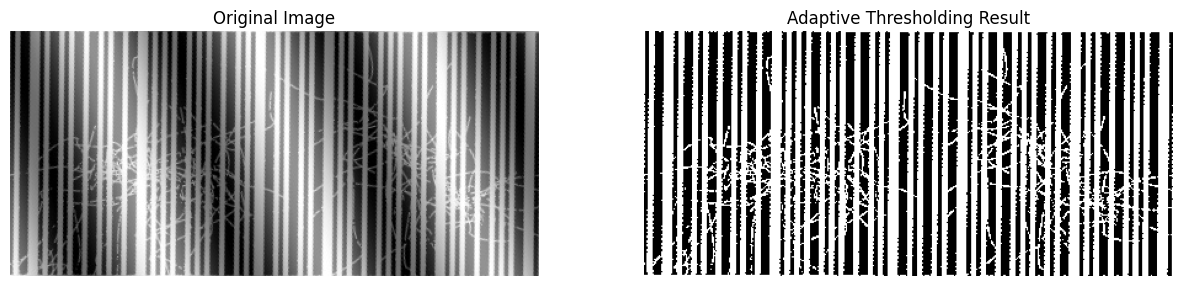

['sine_wave']
0
0
0
0
0
0
0
0
0
0
0
0
0
0
----------------------------------
['Stop/Start', '1', '1', '3', '-', '4', '7', '-', '3', '5', '-', '3', '5', 'Stop/Start']
----------------------------------


Barcode decoded successfully


In [50]:
folder_path = "Test Case Images"
process_images_in_folder(folder_path)